In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay
import random as rd
import matplotlib.pyplot as plt
import seaborn as snb
from sklearn import preprocessing, metrics
from sklearn.neural_network import MLPClassifier
import scipy.stats as st
from warnings import filterwarnings
import numpy as np
from scipy import stats
import xgboost as xgb
import joblib

In [35]:
# Parâmetros utilizados no Gridsearchcv
param_grid_logistic = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    'penalty': ['l1', 'l2', 'elasticnet', 'None'],
    'solver': ['liblinear', 'newton-cholesky']
}

param_grid_deci_tree = {
    'criterion': ['gini', 'entropy', 'log_loss']
}

param_grid_knn = {
    'n_neighbors': [2,3,4,5,6,7,8,9,10, 20, 30, 40, 50],
    'metric': ['cityblock', 'euclidean', 'manhattan']
}

param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
    'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
    'gamma': ['scale', 'auto']
}

param_grid_random_forest = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [10, 100, 200, 300]
}

param_grid_gradient = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': [float(lr/1000.0) for lr in range(1,1000,10)],
    'n_estimators': [n*100 for n in range(10)],
    'criterion': ['friedman_mse', 'squared_error']
}

Vetores que vão armazenar as médias dos classificadores para o teste de Friedman

* Accurácia
* Sensibilidade
* Especificidade
* Taxa de falso positivo

In [36]:
def confidence_interval(values, p):
    mean = np.mean(values)
    std = np.std(values)
    return st.t.interval(alpha=p, df=len(values) - 1, loc=mean, scale=std)

def print_ic(low, high):
  if (high > 1.0):
    high = 1.0
  print("Intervalo de confiança p < 0.95 {} < x < {}".format(low,high))

In [37]:
def gridSearch(model, params, cv, X_train, y_train):
    grid = GridSearchCV(model, params, cv=cv)
    grid_results = grid.fit(X_train, y_train)
    print("Best Params")
    print(grid_results.best_params_)
    return grid_results.best_estimator_

In [38]:
def evaluate_model(model, X_train, y_train, cv, debug = False):
    list_specificity = []
    list_sensibility = []
    list_accuracy = []
    scores = cross_validate(model, X_train, y_train, scoring='accuracy', cv = cv, n_jobs=-1, return_estimator=True)
    estimators = scores['estimator']
    
    if (debug):
        for i, (train_index, test_index) in enumerate(cv.split(X_train)):
    
            X_pred = X_train[test_index]
            y_ground = y_train[test_index]
            y_pred = estimators[0].predict(X_pred)
            tn, fp, fn, tp = confusion_matrix(y_ground, y_pred).ravel()
            sensibility = tp / (tp + fn)
            specificity = tn / (tn + fp)
            accuracy = (tp+tn)/(tp+tn+fp+fn)
            list_sensibility.append(sensibility)
            list_specificity.append(specificity)
            list_accuracy.append(accuracy)
    
            print(f"Fold {i}")
            print(f'Number of samples: {len(X_pred)}')
            print(f"Mean Specificity= {specificity}")
            print(f"Mean Sensibility= {sensibility}\n\n")
  
            ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_ground, y_pred), display_labels=['Non Infart', 'Infart']).plot()
            plt.grid(False)
            plt.show()
    
        print(f"Mean Specificity= {np.mean(list_specificity)} Std: {np.std(list_specificity)}")
        print(f"Mean Sensibility= {np.mean(list_sensibility)}  Std: {np.std(list_sensibility)}")
        print(f"Mean Sensibility= {np.mean(list_sensibility)}  Std: {np.std(list_sensibility)}")
    return scores

In [39]:
def show_roc_curve(classifier, y_true, X):
    y_pred = classifier.predict(X)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    auc = roc_auc_score(y_true, y_pred)
    RocCurveDisplay.from_predictions(y_true, y_pred, pos_label=1)
    return (fpr, tpr, thresholds, auc)

In [40]:
def print_metrics_mean(list_accuracy, list_sensibility, list_specificity, list_false_positive_rate):
    print(f"Mean Specificity= {np.mean(list_specificity)} Std: {np.std(list_specificity)}")
    lower, higher = confidence_interval(list_specificity, 0.95)
    print_ic(lower, higher)
    print(f"Mean Sensibility= {np.mean(list_sensibility)}  Std: {np.std(list_sensibility)}")
    lower, higher = confidence_interval(list_sensibility, 0.95)
    print_ic(lower, higher)
    print(f"Mean Accuracy = {np.mean(list_accuracy)} Sdt: {np.std(list_accuracy)}")
    lower, higher = confidence_interval(list_accuracy, 0.95)
    print_ic(lower, higher)
    print(f"Mean False Positive Rate = {np.mean(list_false_positive_rate)} Sdt: {np.std(list_false_positive_rate)}")
    lower, higher = confidence_interval(list_false_positive_rate, 0.95)
    print_ic(lower, higher)

In [41]:
def evaluate_kfold(list_of_estimators, X_total, y_total):
    # Verificando a media com todos os elementos e classificadores
    list_sensibility = []
    list_specificity = []
    list_false_positive_rate = []
    list_accuracy = []
    X_pred = X_total
    y_truth = y_total
    
    for i, estimator in enumerate(list_of_estimators):
  
        y_pred = estimator.predict(X_pred)
        tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
        sensibility = tp / (tp + fn)
        specificity = tn / (tn + fp)
        sensibility = tp / (tp + fn)
        false_positive_rate = 1 - specificity
        accuracy = (tp+tn)/(tp+tn+fp+fn)
       
        print(f'Estimator {i}')
        print(f"Accuracy = {accuracy}")
        print(f"Specificity = {specificity}")
        print(f"Sensibility = {sensibility}")
        print(f'False Positive rate: {false_positive_rate}')
        
        # Appending Lists
        list_sensibility.append(sensibility)
        list_specificity.append(specificity)
        list_false_positive_rate.append(false_positive_rate)
        list_accuracy.append(accuracy)
        
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_truth, y_pred), display_labels=['Negative', 'Positive']).plot()
        show_roc_curve(estimator, y_truth, X_total)
        plt.grid(False)
        plt.show()

    print_metrics_mean(list_accuracy, list_sensibility, list_specificity, list_false_positive_rate)
    return (list_accuracy, list_sensibility, list_specificity, list_false_positive_rate)


In [9]:
def print_metrics(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensibility = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensibility = tp / (tp + fn)
    false_positive_rate = 1 - specificity
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    
    print("--"*20)
    print(f"Accuracy = {accuracy}")
    print(f"Specificity = {specificity}")
    print(f"Sensibility = {sensibility}")
    print(f'False Positive rate: {false_positive_rate}')
    print("--"*20)

In [10]:
def evaluate_estimator(classifier, x, y):
    y_pred = classifier.predict(x)
    print_metrics(y, y_pred)
   

In [11]:
def get_best_classifier(scores):
    return scores['estimator'][np.argmax(scores['test_score'])]

In [12]:
# Seed
seed = 42

In [13]:
# For windows
#df = pd.read_csv('C:\\Users\\pveso\\Documents\\heart_attack_analysis\\data\\hepatite_fourier.csv', index_col=0)
df = pd.read_csv('C:\\Users\\pveso\\Documents\\heart_attack_analysis\\data\\hepatitis.csv', index_col=0)
#comertial_test_1 = pd.read_csv('C:\\Users\\pves\\Documents\\Voxar_Contexto\\Workspace\\heart_attack_analysis\\src\\comertial_virgin.csv', index_col=0)
#comertial_test_2 = pd.read_csv('C:\\Users\\pves\\Documents\\Voxar_Contexto\\Workspace\\heart_attack_analysis\\src\\comertial_rodamine.csv', index_col=0)
#polimid_test_1 = pd.read_csv('/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/src/polimid_virgin.csv', index_col=0)
#polimid_test_2 = pd.read_csv('/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/src/polimid_rodamine.csv', index_col=0)
#test_df = pd.concat([comertial_test_2], axis=0, ignore_index=True)
#test_df = pd.concat([comertial_test_1, comertial_test_2], axis=0, ignore_index=True)
#test_df['target'] = np.zeros(shape=(test_df.shape[0],), dtype=int)

In [ ]:
df = pd.read_csv('../data/complete_dataset.csv', index_col=0)
comertial_test_1 = pd.read_csv('/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/src/comertial_virgin.csv', index_col=0)
comertial_test_2 = pd.read_csv('/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/src/comertial_rodamine.csv', index_col=0)
polimid_test_1 = pd.read_csv('/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/src/polimid_virgin.csv', index_col=0)
polimid_test_2 = pd.read_csv('/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/src/polimid_rodamine.csv', index_col=0)
test_df = pd.concat([comertial_test_1, comertial_test_2, polimid_test_1, polimid_test_2], axis=0, ignore_index=True)
#test_df = pd.concat([comertial_test_1, comertial_test_2], axis=0, ignore_index=True)
test_df['target'] = np.zeros(shape=(test_df.shape[0],), dtype=int)

In [14]:
df.head()

,time_mean,time_std,time_mad,time_max,time_min,energy,iqr,entropy,dft_mean,kurtosis,skewness,time_area,dc,target
0,4.781481,4.762474,1.867302,19.729401,0.0,45.543716,5.525452,6.920790,0.392101,36.704391,5.509712,620.807251,9.562962,0.0
1,6.640722,6.070823,3.772003,23.749199,0.0,80.954086,8.542500,6.884493,0.563606,43.185799,5.951580,860.161499,13.281444,0.0
2,7.265351,6.474499,4.312004,24.893997,0.0,94.704468,9.329002,6.987621,0.567424,44.641535,6.110370,942.545959,14.530706,0.0
3,7.286970,6.712417,4.605202,25.973999,0.0,98.156464,9.640553,6.941820,0.591783,43.030356,6.029700,944.599609,14.573938,0.0
4,5.613905,5.073607,2.829002,18.227997,0.0,57.257412,7.548500,6.905523,0.482295,43.469679,5.896707,726.801514,11.227811,0.0


In [15]:
df.tail()

,time_mean,time_std,time_mad,time_max,time_min,energy,iqr,entropy,dft_mean,kurtosis,skewness,time_area,dc,target
35,7.394682,6.984324,4.412994,22.944000,0.0,103.462112,10.917503,6.844454,0.695483,42.190546,5.872203,955.789429,14.789365,1.0
36,6.109778,6.288691,2.169800,21.460701,0.0,76.877029,9.260452,6.859722,0.588356,36.652415,5.552765,788.991699,12.219559,1.0
37,6.957294,6.549401,4.093002,21.981995,0.0,91.298592,10.107498,6.972354,0.643679,42.145665,5.872985,899.424988,13.914589,1.0
38,6.099709,6.006722,2.591003,20.581497,0.0,73.287163,8.949596,6.890256,0.570028,39.160872,5.704267,787.750183,12.199418,1.0
39,5.156744,5.537714,1.821899,20.124001,0.0,57.258289,8.496098,6.859722,0.478019,33.787140,5.376626,666.744385,10.313486,1.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time_mean  40 non-null     float64
 1   time_std   40 non-null     float64
 2   time_mad   40 non-null     float64
 3   time_max   40 non-null     float64
 4   time_min   40 non-null     float64
 5   energy     40 non-null     float64
 6   iqr        40 non-null     float64
 7   entropy    40 non-null     float64
 8   dft_mean   40 non-null     float64
 9   kurtosis   40 non-null     float64
 10  skewness   40 non-null     float64
 11  time_area  40 non-null     float64
 12  dc         40 non-null     float64
 13  target     40 non-null     float64
dtypes: float64(14)
memory usage: 4.7 KB


In [ ]:
test_df.head()

In [ ]:
test_df.tail()

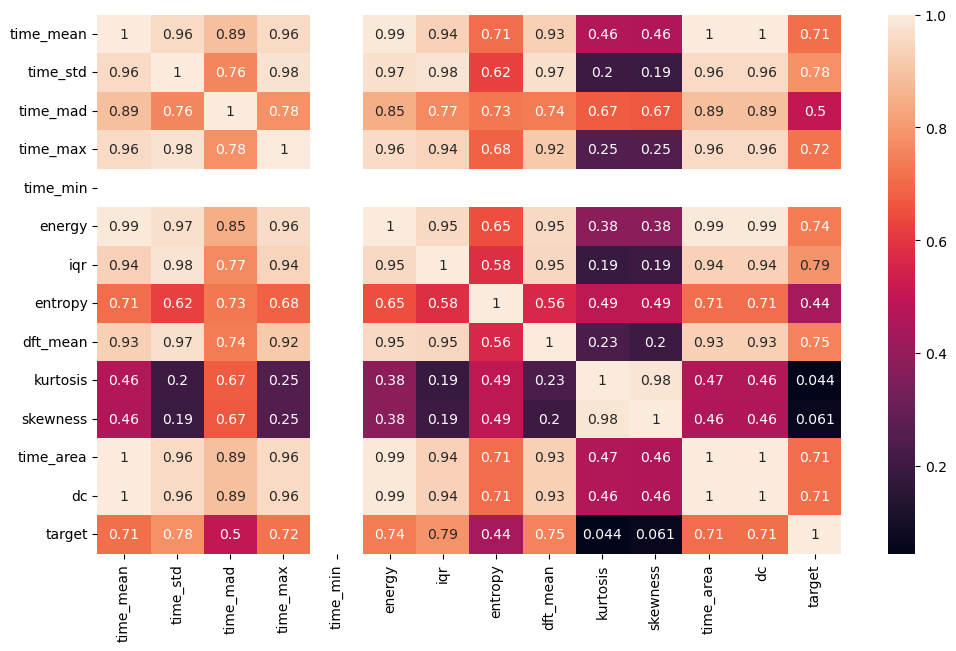

In [18]:
fig, ax = plt.subplots(figsize=(12,7))
ax = snb.heatmap(df.iloc[:,:].corr(), annot=True)
plt.show()

# Experimento apenas com menos features

Como algumas features são bem relacionadas umas com as outras eu vou pegar apenas:\\
* 1 - Pico da derivada anódica
* 2 - Diferença potencial anódico e catódico
* 3 - Diferença entre corrente anódica e catódica

In [20]:
# Preparando os dados
X_less_features = df[['time_mean', 'time_std', 'time_max', 'energy', 'iqr', 'dft_mean', 'time_area', 'dc']]
y = df['target']

scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X_less_features.values)
print(f"Scale_Mean: {scaler.mean_} Scale_Std: {scaler.scale_}")
X_train = scaler.transform(X_less_features.values)
cv = StratifiedKFold(n_splits = 5, random_state=seed, shuffle=True)
(x_train, x_test, y_train, y_test) = train_test_split(X_train, y.values, test_size=0.30, random_state=seed)

Scale_Mean: [5.59568672e+00 5.38660276e+00 1.93916182e+01 6.47365509e+01
 7.87831736e+00 5.05394831e-01 7.23484058e+02 1.11913737e+01] Scale_Std: [1.57519155e+00 1.38856881e+00 4.91533145e+00 3.18401426e+01
 2.22933252e+00 1.38131221e-01 2.04296278e+02 3.15038338e+00]


In [21]:
# Saving the standard scaler parameters
from joblib import dump, load
import os
base_path = os.path.abspath(os.getcwd())
filename = os.path.join(base_path, "Hep\\std_scaler.bin")
print(filename)
if len(dump(scaler, filename, compress = True)) > 0:
    print("Save with success")

c:\Users\pveso\Documents\heart_attack_analysis\src\Hep\std_scaler.bin
Save with success


In [22]:
x_total = np.concatenate([x_train, x_test], axis=0)
y_total = np.concatenate([y_train, y_test], axis=0)

In [29]:
scaler.transform(X_less_features.values[20].reshape(1,-1))

array([[-0.22632074, -0.31104408, -0.01676673, -0.40007458, -0.58951233,
        -0.48293963, -0.21989214, -0.2263202 ]])

In [58]:
# Preparando os dados
#X = df.iloc[:,:-1]
#X.drop('carga', axis=1, inplace=True)
#x_sanity = test_df.iloc[:,:-1]
#x_sanity.drop('carga', axis=1, inplace=True)
#y_sanity = test_df['target'].values
#y = df['target']
(x_train, x_test, y_train, y_test) = train_test_split(X_train, y.values, test_size=0.30, random_state=seed)
#y_test = test_df['target']
#X_test = test_df.iloc[:,:-1].drop(['carga'], axis=1)

#scaler = preprocessing.StandardScaler()
#scaler = scaler.fit(X.values)
#X_train = scaler.transform(X.values)
#X_test = scaler.transform(X_test.values)
#x_train = scaler.transform(x_train)
#x_test = scaler.transform(x_test)
#x_sanity = scaler.transform(x_sanity.values)
x_total = np.concatenate([x_train, x_test], axis=0)
y_total = np.concatenate([y_train, y_test], axis=0)
#cv = KFold(n_splits = 5, random_state=seed, shuffle=True)

In [30]:
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)
#print(x_total.shape)
#print(y_total.shape)
#print(x_sanity.shape)
#print(y_sanity.shape)

(12, 8)
(12,)
(28, 8)
(28,)


In [31]:
pd.DataFrame(y_test).value_counts()

0.0    7
1.0    5
dtype: int64

In [32]:
pd.DataFrame(y_train).value_counts()

1.0    15
0.0    13
dtype: int64

In [33]:

print(x_train.mean())
print(x_train.std())
print(x_test.mean())
print(x_test.std())
#print(x_sanity.mean())
#print(x_sanity.std())

0.11690282586288872
0.9927822706993108
-0.2727732603467404
0.9629475394766092


## Logistic Regression

c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
210 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\linear_model\_logistic.py", li

Best Params
{'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Estimator 0
Accuracy = 0.9166666666666666
Specificity = 1.0
Sensibility = 0.8
False Positive rate: 0.0


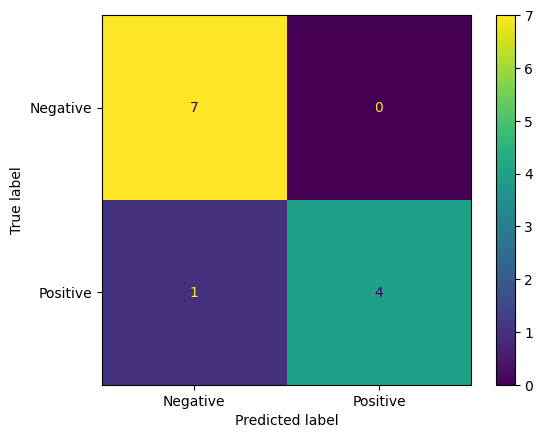

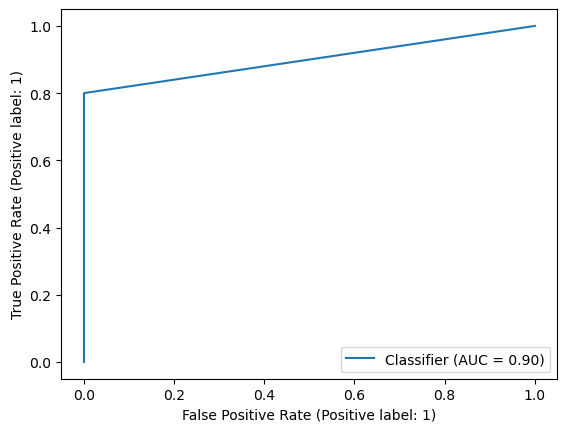

Estimator 1
Accuracy = 0.9166666666666666
Specificity = 1.0
Sensibility = 0.8
False Positive rate: 0.0


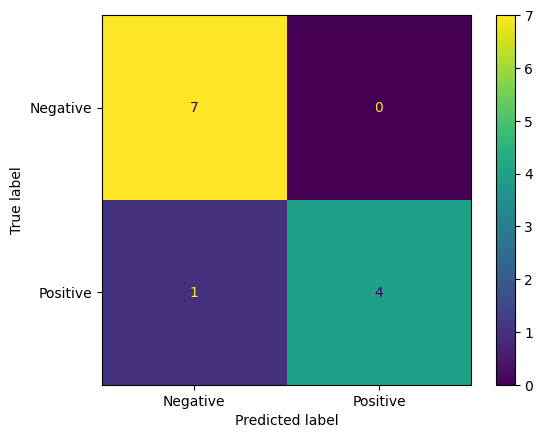

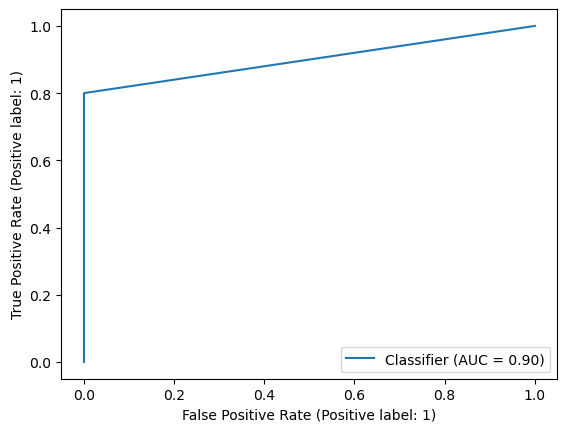

Estimator 2
Accuracy = 0.9166666666666666
Specificity = 1.0
Sensibility = 0.8
False Positive rate: 0.0


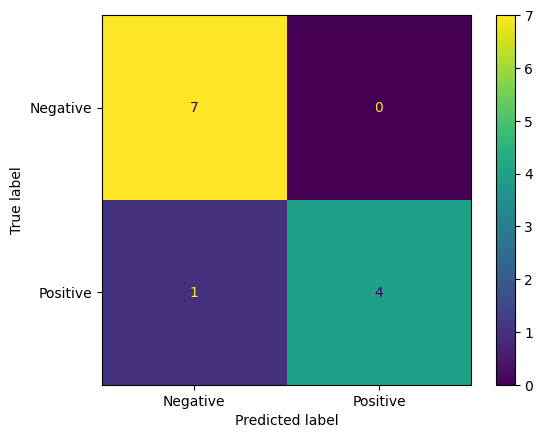

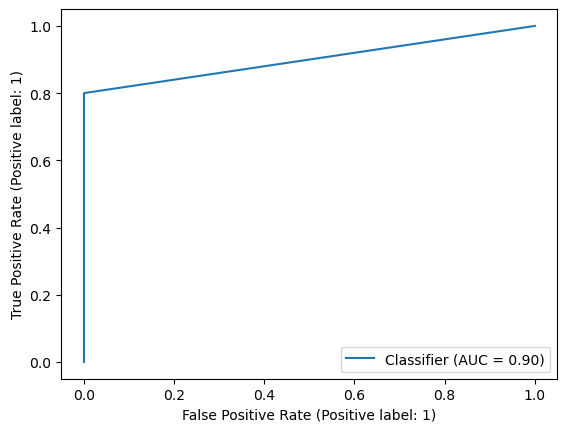

Estimator 3
Accuracy = 0.9166666666666666
Specificity = 1.0
Sensibility = 0.8
False Positive rate: 0.0


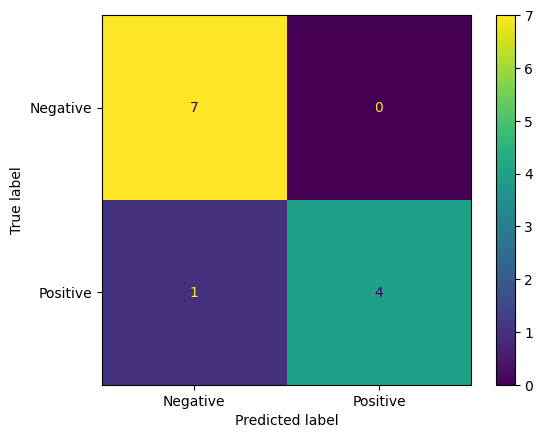

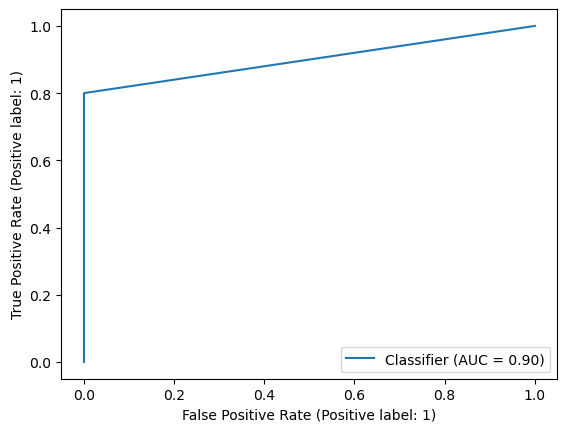

Estimator 4
Accuracy = 0.9166666666666666
Specificity = 1.0
Sensibility = 0.8
False Positive rate: 0.0


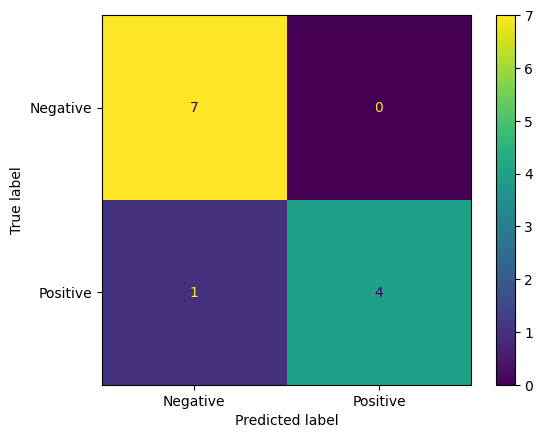

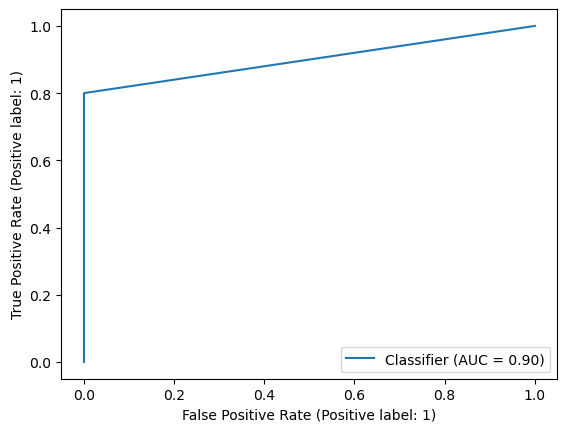

Mean Specificity= 1.0 Std: 0.0
Intervalo de confiança p < 0.95 nan < x < nan
Mean Sensibility= 0.8  Std: 0.0
Intervalo de confiança p < 0.95 nan < x < nan
Mean Accuracy = 0.9166666666666666 Sdt: 0.0
Intervalo de confiança p < 0.95 nan < x < nan
Mean False Positive Rate = 0.0 Sdt: 0.0
Intervalo de confiança p < 0.95 nan < x < nan


c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [109]:
model = LogisticRegression(max_iter=1000, random_state=seed)
model = gridSearch(model, param_grid_logistic, cv, x_train, y_train)
scores_logistic = evaluate_model(model, x_train, y_train, cv)
logistic_best = get_best_classifier(scores_logistic)
estimators_logistic = scores_logistic['estimator']
(list_accuracy_logistic, list_sensibility_logistic, list_specificity_logistic, list_false_positive_rate_logistic) = evaluate_kfold(estimators_logistic, x_test, y_test)

In [54]:
# # Verificando a media com todos os elementos e classificadores da regressão logística
# list_sensibility_logistic = []
# list_specificity_logistic = []
# list_false_positive_rate_logistic = []
# list_accuracy_logistic = []

# for i, estimator in enumerate(scores['estimator']):
#     print(f'Estimator {i}\n\n')
#     X_pred = x_total
#     y_truth = y_total
#     y_pred = estimator.predict(X_pred)
#     tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
#     sensibility = tp / (tp + fn)
#     specificity = tn / (tn + fp)
#     false_positive_rate = 1 - specificity
#     accuracy = (tp+tn)/(tp+tn+fp+fn)
#     print(f'Number of samples: {len(X_pred)}')
#     print(f"Accuracy = {accuracy}")
#     print(f"Specificity= {specificity}")
#     print(f"Sensibility= {sensibility}")
#     print(f'False Positive rate: {false_positive_rate}\n\n')
#     list_sensibility_logistic.append(sensibility)
#     list_specificity_logistic.append(specificity)
#     list_accuracy_logistic.append(accuracy)
  
#     ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_truth, y_pred), display_labels=['Non Infart', 'Infart']).plot()
#     show_roc_curve(estimator, y_truth, X_pred)
#     plt.grid(False)
#     plt.show()

# print(f"Mean Specificity= {np.mean(list_specificity_logistic)} Std: {np.std(list_specificity_logistic)}")
# print(f"Mean Sensibility= {np.mean(list_sensibility_logistic)}  Std: {np.std(list_sensibility_logistic)}")
# print(f"Mean Accuracy = {np.mean(list_accuracy_logistic)} Sdt: {np.std(list_accuracy_logistic)}")

In [66]:
def marjoritary_vote(estimators, x_values):
    pred_list = np.zeros(shape=(len(estimators), x_values.shape[0]), dtype=int)
    predictions = np.zeros(shape=(x_values.shape[0],), dtype=int)
    
    for i in range(len(estimators)):
        pred_list[i] = estimators[i].predict(x_values)
    
    
    for j in range(pred_list.shape[1]):
        vote_0 = 0
        vote_1 = 0
        for i in range(pred_list.shape[0]):
            vote = pred_list[i,j]
            if (vote == 0):
                vote_0 += 1
            else:
                vote_1 += 1
        if (vote_1 > vote_0):
            predictions[j] = 1
    return predictions
        

def majoritary_voting_pred(estimators, X_test):
    
    pred_list = []
    
    for i in range(X_test.shape[0]):
        sum_0 = 0
        sum_1 = 0
    
        for est in estimators:
            pred = est.predict(X_test[i])
        
            if (pred == 0):
                sum_0 += 1
            else:
                sum_1 = 1
    
        if sum_1 > sum_0:
            pred_list.append(1)
        else:
            pred_list.append(0)
        
    return pred_list

def calc_accuracy(y_truth, y_pred):

    assert len(y_truth) == len(y_pred)
    
    n_of_right = 0
     
    for i in range(len(y_pred)):
        if y_truth[i] == y_pred[i]:
            n_of_right += 1
    
    return (n_of_right / len(y_truth)) * 1.0
        

In [56]:
# best_logistic_regression = scores['estimator'][np.argmax(scores['test_score'])]

In [110]:
# Avaliando o melhor estimador da regressão logística com todo o conjunto
evaluate_estimator(logistic_best, x_total, y_total)

----------------------------------------
Accuracy = 0.875
Specificity = 0.85
Sensibility = 0.9
False Positive rate: 0.15000000000000002
----------------------------------------


In [111]:
evaluate_estimator(logistic_best, x_test, y_test)

----------------------------------------
Accuracy = 0.9166666666666666
Specificity = 1.0
Sensibility = 0.8
False Positive rate: 0.0
----------------------------------------


In [111]:
#logistic_best.predict(x_sanity)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [69]:
# Utilizando um conjunto de amostras de eletrodo comercial apenas modificadas e não modificadas com Rodamina
estimators = scores_logistic['estimator']
pred = marjoritary_vote(estimators, x_test)
print_metrics(y_test, pred)

----------------------------------------
Accuracy = 0.9166666666666666
Specificity = 1.0
Sensibility = 0.8
False Positive rate: 0.0
----------------------------------------


## KNN

c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\neighbors\_classification.py", line 214, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages

Best Params
{'metric': 'cityblock', 'n_neighbors': 5}
Estimator 0
Accuracy = 0.9166666666666666
Specificity = 0.8571428571428571
Sensibility = 1.0
False Positive rate: 0.1428571428571429


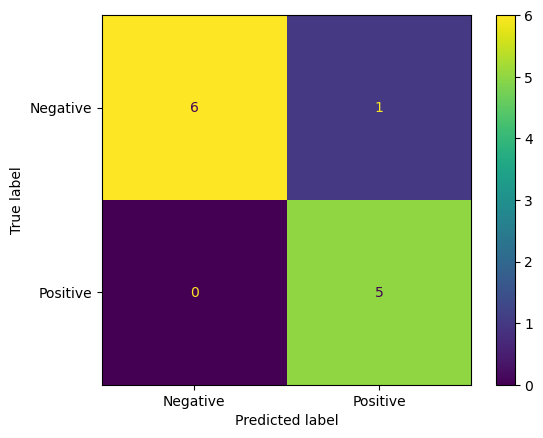

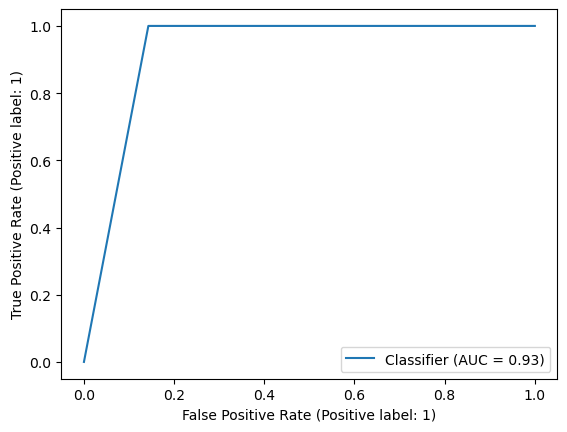

Estimator 1
Accuracy = 0.9166666666666666
Specificity = 0.8571428571428571
Sensibility = 1.0
False Positive rate: 0.1428571428571429


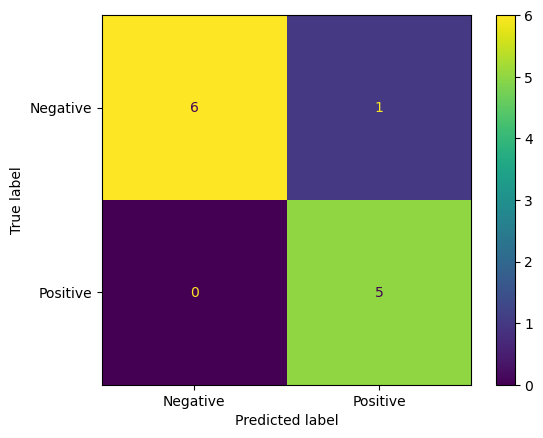

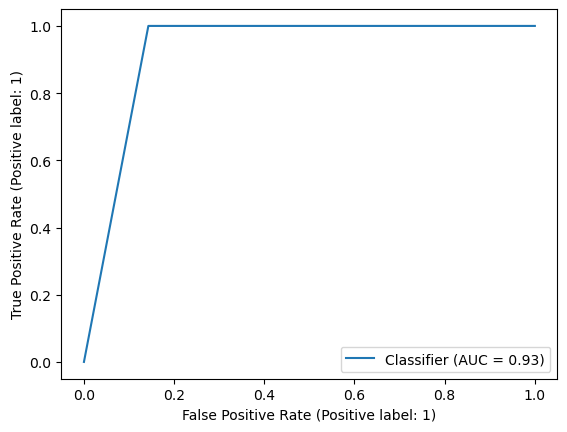

Estimator 2
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


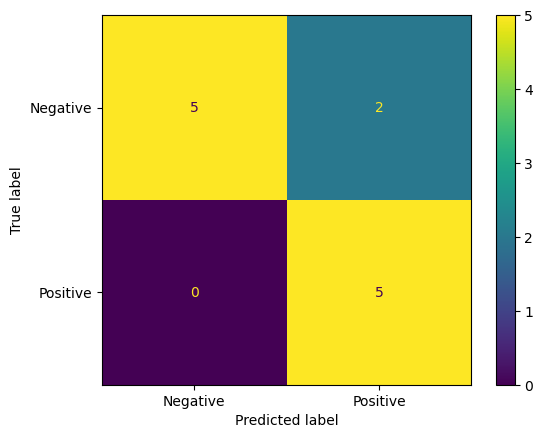

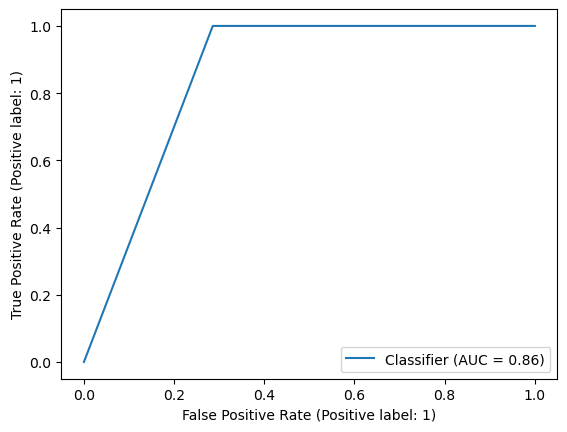

Estimator 3
Accuracy = 0.8333333333333334
Specificity = 0.8571428571428571
Sensibility = 0.8
False Positive rate: 0.1428571428571429


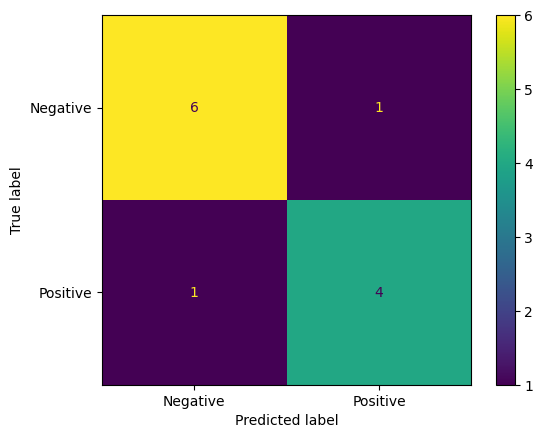

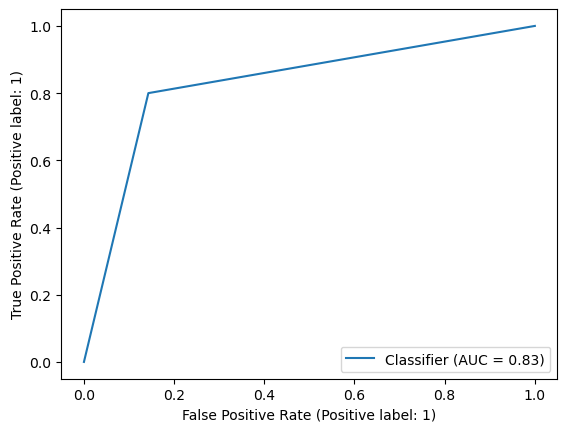

Estimator 4
Accuracy = 0.9166666666666666
Specificity = 0.8571428571428571
Sensibility = 1.0
False Positive rate: 0.1428571428571429


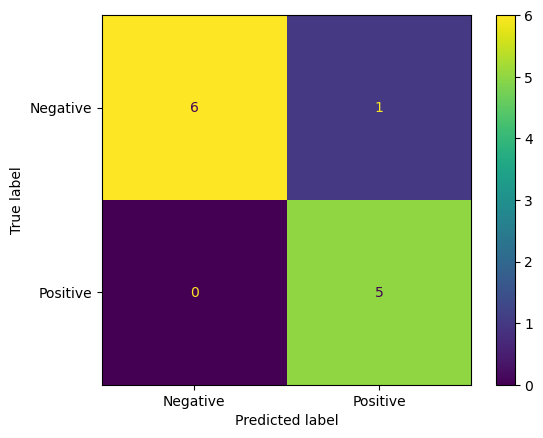

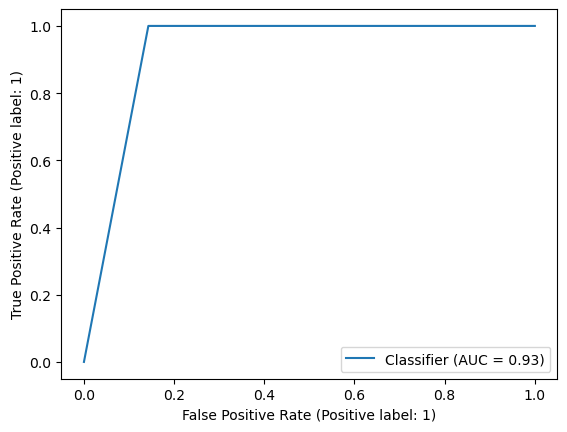

Mean Specificity= 0.8285714285714285 Std: 0.05714285714285711
Intervalo de confiança p < 0.95 0.6699174225601259 < x < 0.9872254345827312
Mean Sensibility= 0.96  Std: 0.07999999999999999
Intervalo de confiança p < 0.95 0.7378843915841761 < x < 1.0
Mean Accuracy = 0.8833333333333334 Sdt: 0.04082482904638626
Intervalo de confiança p < 0.95 0.7699854365569574 < x < 0.9966812301097094
Mean False Positive Rate = 0.17142857142857146 Sdt: 0.05714285714285712
Intervalo de confiança p < 0.95 0.012774565417268735 < x < 0.3300825774398742


In [112]:
model = KNeighborsClassifier()
model = gridSearch(model, param_grid_knn, cv, x_train, y_train)
scores_knn = evaluate_model(model, x_train, y_train, cv)
knn_best = get_best_classifier(scores_knn)
estimators_knn = scores_knn['estimator']
(list_accuracy_knn, list_sensibility_knn, list_specificity_knn, list_false_positive_rate_knn) = evaluate_kfold(estimators_knn,  x_test, y_test)

In [113]:
evaluate_estimator(knn_best, x_total, y_total)

----------------------------------------
Accuracy = 0.9
Specificity = 0.8
Sensibility = 1.0
False Positive rate: 0.19999999999999996
----------------------------------------


In [114]:
evaluate_estimator(knn_best, x_test, y_test)

----------------------------------------
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857
----------------------------------------


In [75]:
pred = marjoritary_vote(estimators_knn, x_total)
print_metrics(y_total, pred)

----------------------------------------
Accuracy = 0.875
Specificity = 0.8
Sensibility = 0.95
False Positive rate: 0.19999999999999996
----------------------------------------


In [90]:
knn_best.predict(x_sanity)

NameError: name 'x_sanity' is not defined

## Decision Tree

c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\tree\_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\tree\_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion

Best Params
{'criterion': 'gini'}
Estimator 0
Accuracy = 0.8333333333333334
Specificity = 0.8571428571428571
Sensibility = 0.8
False Positive rate: 0.1428571428571429


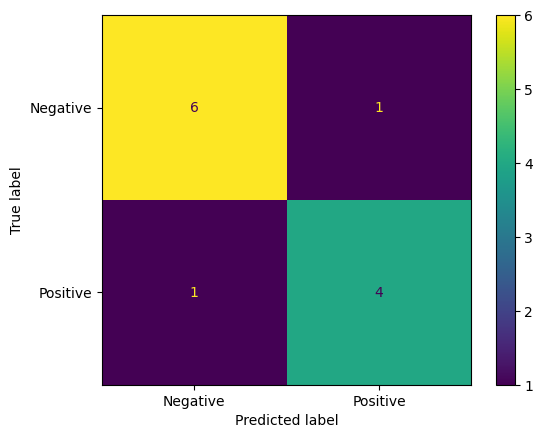

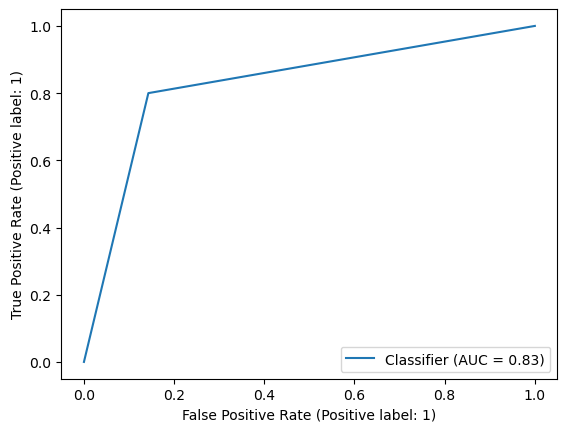

Estimator 1
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


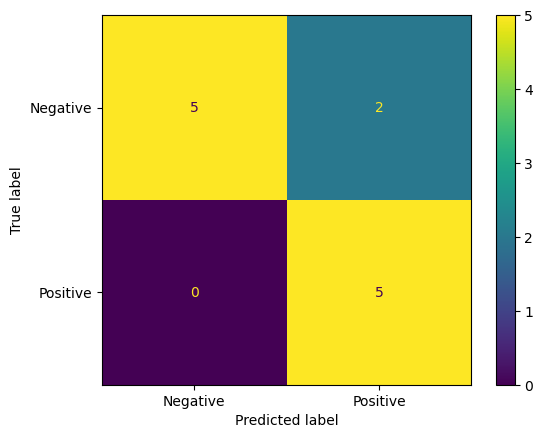

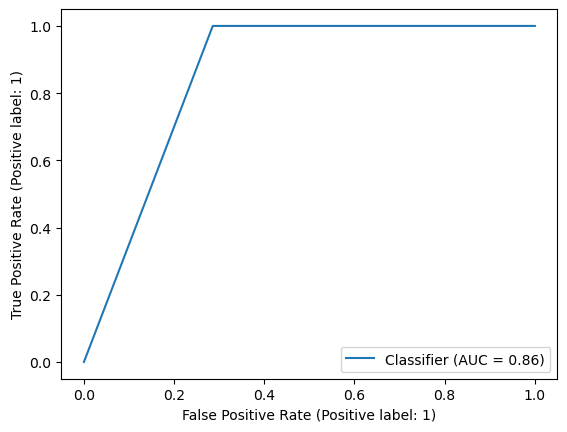

Estimator 2
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


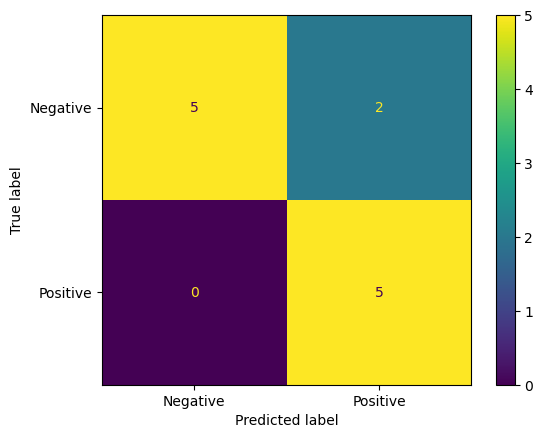

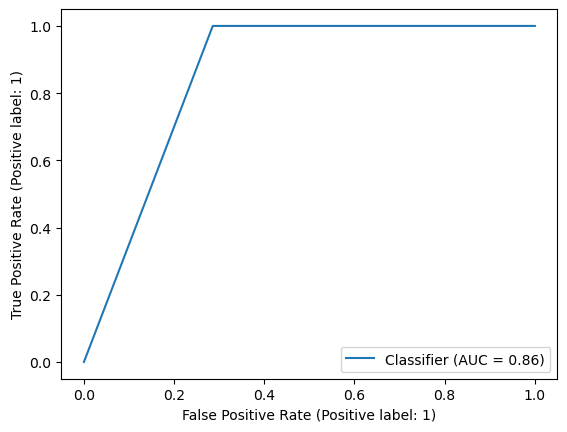

Estimator 3
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


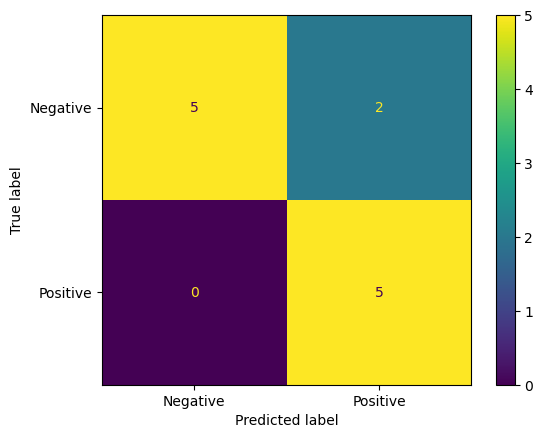

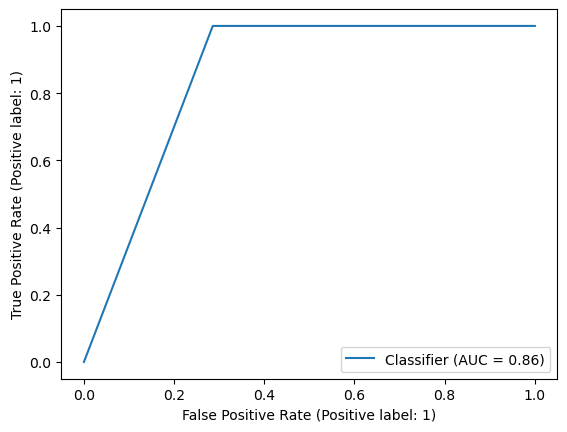

Estimator 4
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


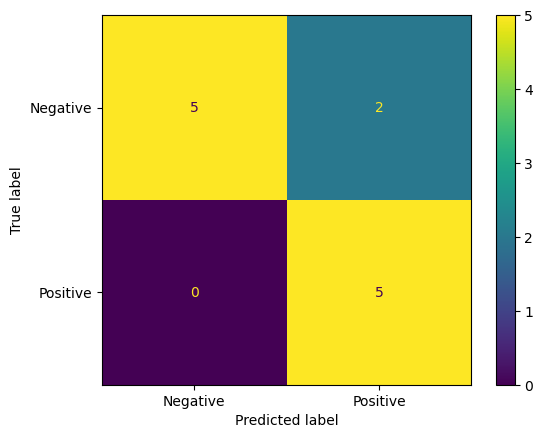

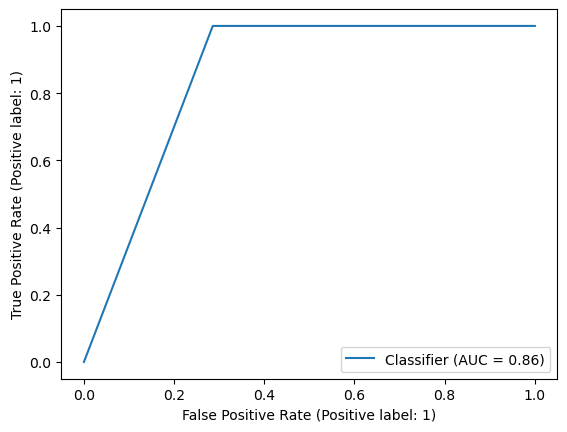

Mean Specificity= 0.7428571428571429 Std: 0.05714285714285712
Intervalo de confiança p < 0.95 0.5842031368458401 < x < 0.9015111488684456
Mean Sensibility= 0.96  Std: 0.07999999999999999
Intervalo de confiança p < 0.95 0.7378843915841761 < x < 1.0
Mean Accuracy = 0.8333333333333334 Sdt: 0.0
Intervalo de confiança p < 0.95 nan < x < nan
Mean False Positive Rate = 0.2571428571428571 Sdt: 0.05714285714285712
Intervalo de confiança p < 0.95 0.0984888511315544 < x < 0.41579686315415987


c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [115]:
model = DecisionTreeClassifier(random_state=seed)
model = gridSearch(model, param_grid_deci_tree, cv, x_train, y_train)
scores_tree = evaluate_model(model, x_train, y_train, cv)
best_tree = get_best_classifier(scores_tree)
estimators_tree = scores_tree['estimator']
(list_accuracy_tree, list_sensibility_tree, list_specificity_tree, list_false_positive_rate_tree) = evaluate_kfold(estimators_tree,  x_test, y_test)

In [116]:
evaluate_estimator(best_tree, x_total, y_total)

----------------------------------------
Accuracy = 0.95
Specificity = 0.9
Sensibility = 1.0
False Positive rate: 0.09999999999999998
----------------------------------------


In [117]:
evaluate_estimator(best_tree, x_test, y_test)

----------------------------------------
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857
----------------------------------------


In [118]:
pred = marjoritary_vote(estimators_tree, x_total)
#print(pred)
print_metrics(y_total, pred)

----------------------------------------
Accuracy = 0.95
Specificity = 0.9
Sensibility = 1.0
False Positive rate: 0.09999999999999998
----------------------------------------


In [119]:
pred = marjoritary_vote(estimators_tree, x_test)
#print(pred)
print_metrics(y_test, pred)

----------------------------------------
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857
----------------------------------------


In [122]:
best_tree.predict(x_sanity)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

## Support Vector Machine

Best Params
{'C': 100.0, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Estimator 0
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


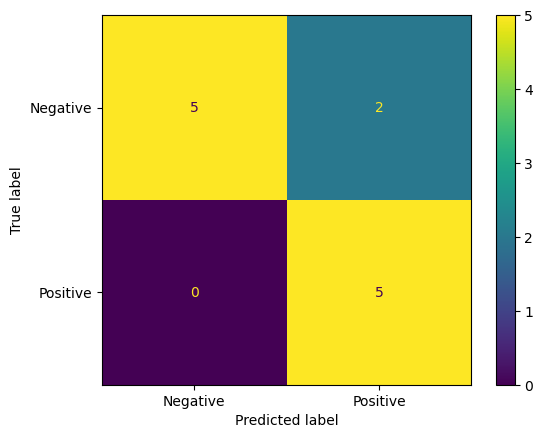

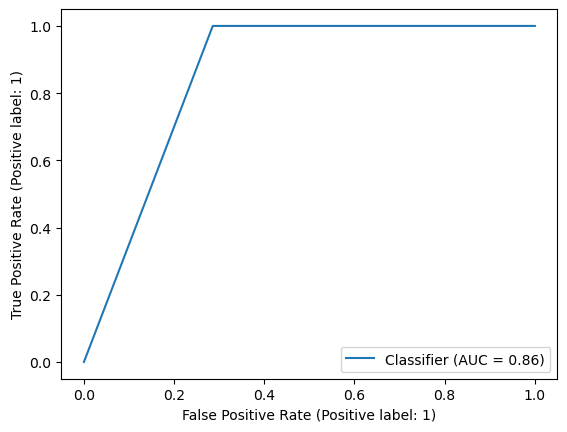

Estimator 1
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


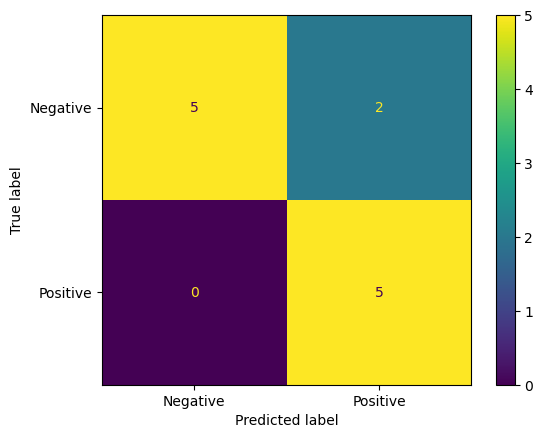

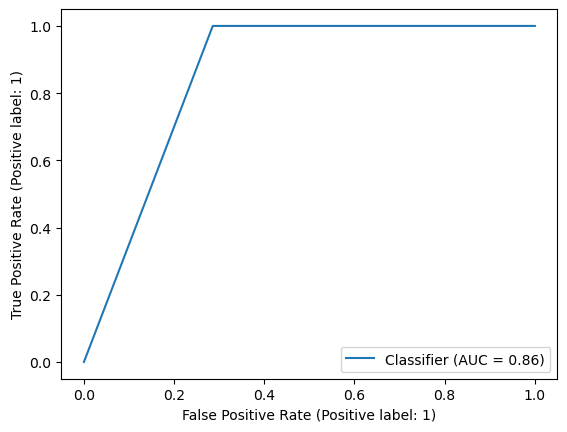

Estimator 2
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


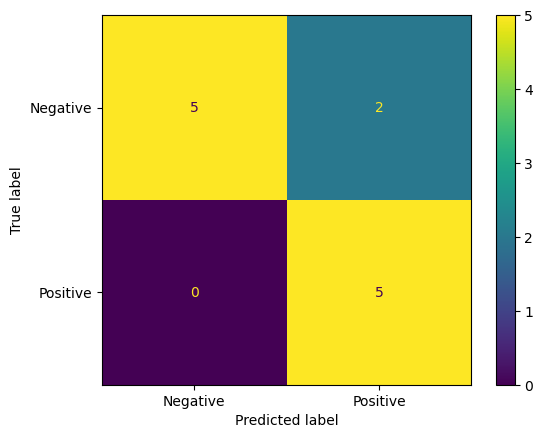

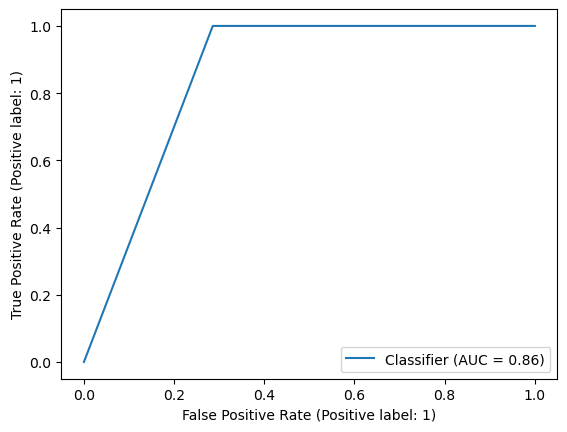

Estimator 3
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


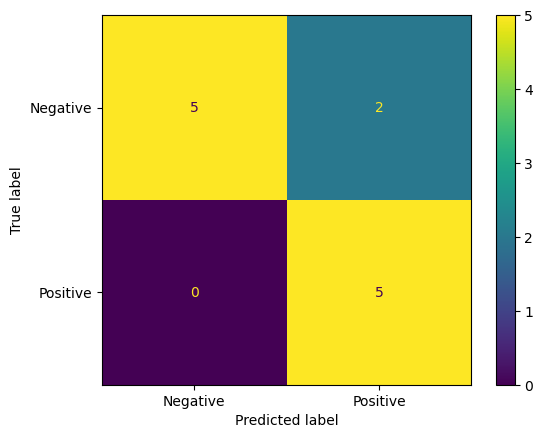

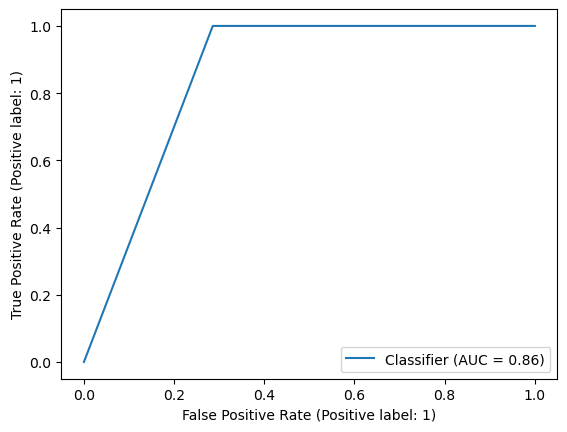

Estimator 4
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


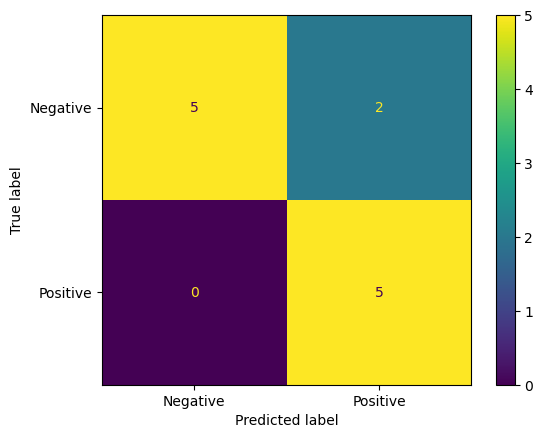

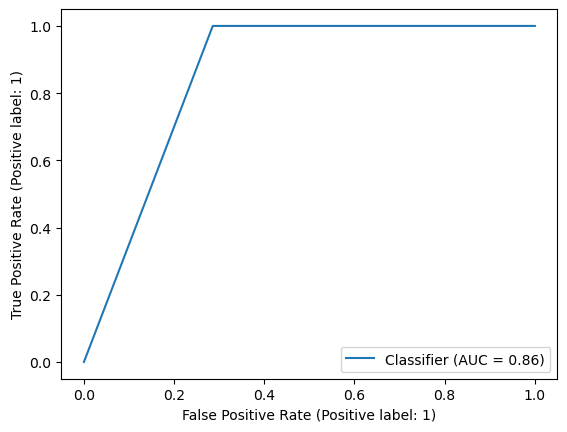

Mean Specificity= 0.7142857142857143 Std: 0.0
Intervalo de confiança p < 0.95 nan < x < nan
Mean Sensibility= 1.0  Std: 0.0
Intervalo de confiança p < 0.95 nan < x < nan
Mean Accuracy = 0.8333333333333334 Sdt: 0.0
Intervalo de confiança p < 0.95 nan < x < nan
Mean False Positive Rate = 0.2857142857142857 Sdt: 0.0
Intervalo de confiança p < 0.95 nan < x < nan


c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [120]:
model = SVC(random_state=seed, probability=True)
model = gridSearch(model, param_grid_svm, cv, x_train, y_train)
scores_svm = evaluate_model(model, x_train, y_train, cv)
estimators_svm = scores_svm['estimator']
best_svm = get_best_classifier(scores_svm)
(list_accuracy_svc, list_sensibility_svc, list_specificity_svc, list_false_positive_rate_svc) = evaluate_kfold(estimators_svm,  x_test, y_test)

In [121]:
evaluate_estimator(best_svm, x_total, y_total)

----------------------------------------
Accuracy = 0.95
Specificity = 0.9
Sensibility = 1.0
False Positive rate: 0.09999999999999998
----------------------------------------


In [122]:
evaluate_estimator(best_svm, x_test, y_test)

----------------------------------------
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857
----------------------------------------


In [123]:
pred = marjoritary_vote(estimators_svm, x_total)
#print(pred)
print_metrics(y_total, pred)

----------------------------------------
Accuracy = 0.95
Specificity = 0.9
Sensibility = 1.0
False Positive rate: 0.09999999999999998
----------------------------------------


In [124]:
pred = marjoritary_vote(estimators_svm, x_test)
#print(pred)
print_metrics(y_test, pred)

----------------------------------------
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857
----------------------------------------


In [127]:
best_svm.predict(x_sanity)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

## Random Forest

c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\ensemble\_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(itera

Best Params
{'criterion': 'gini', 'n_estimators': 300}
Estimator 0
Accuracy = 0.9166666666666666
Specificity = 0.8571428571428571
Sensibility = 1.0
False Positive rate: 0.1428571428571429


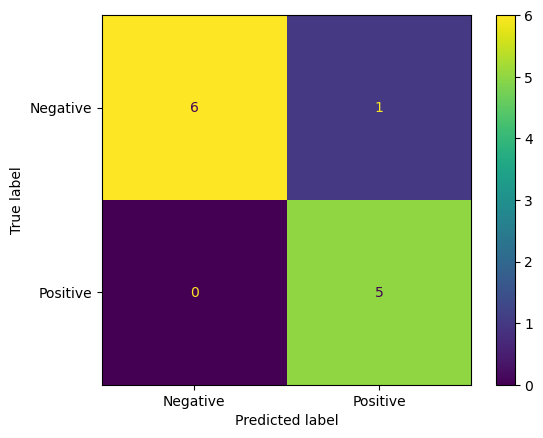

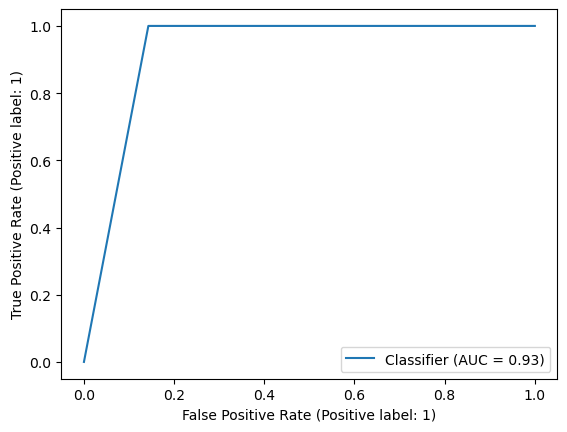

Estimator 1
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


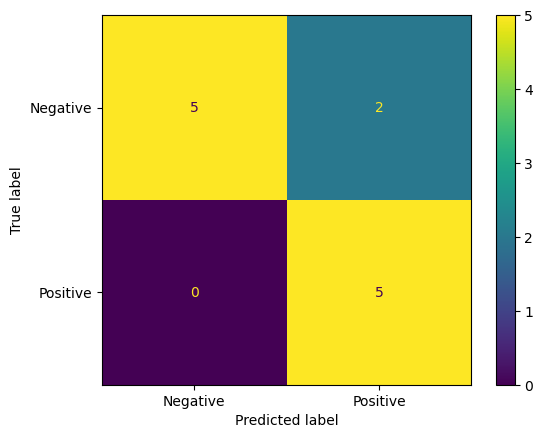

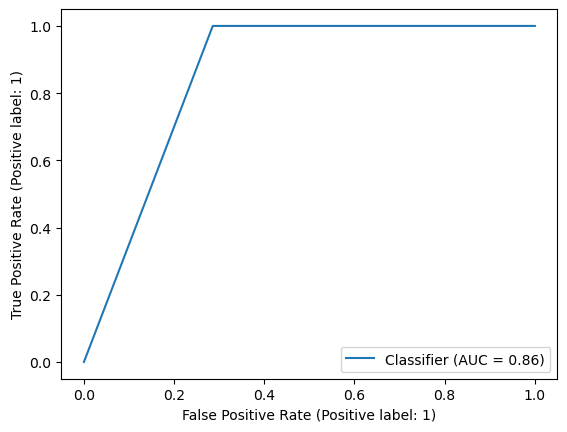

Estimator 2
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


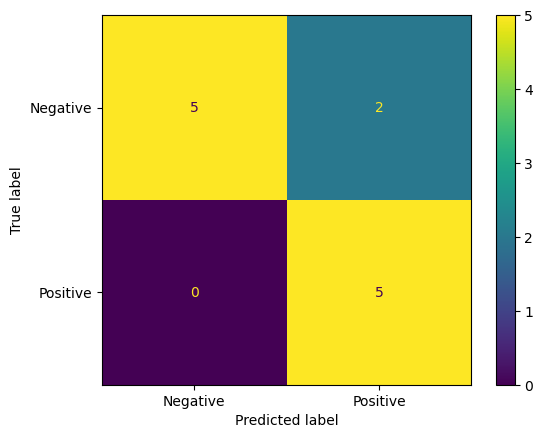

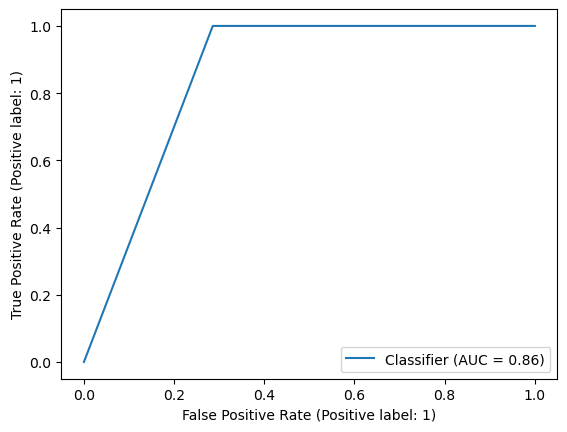

Estimator 3
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


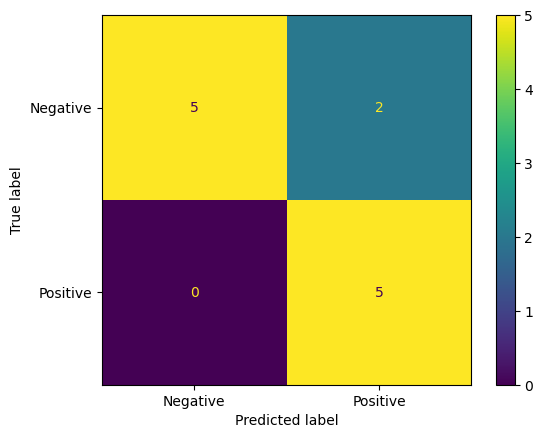

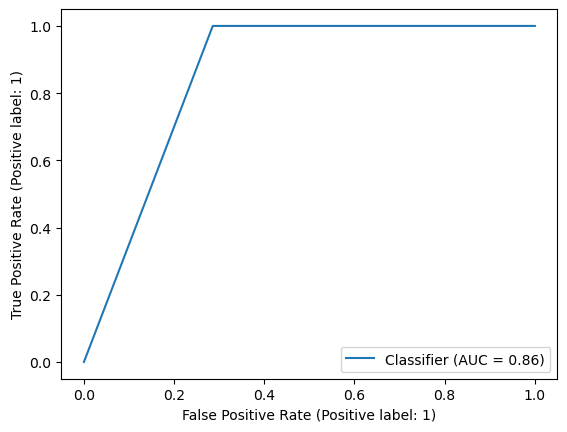

Estimator 4
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


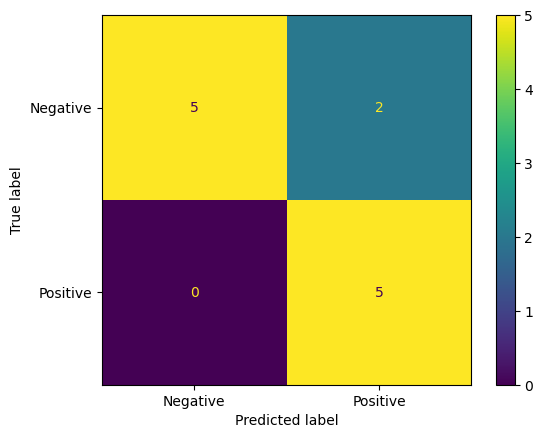

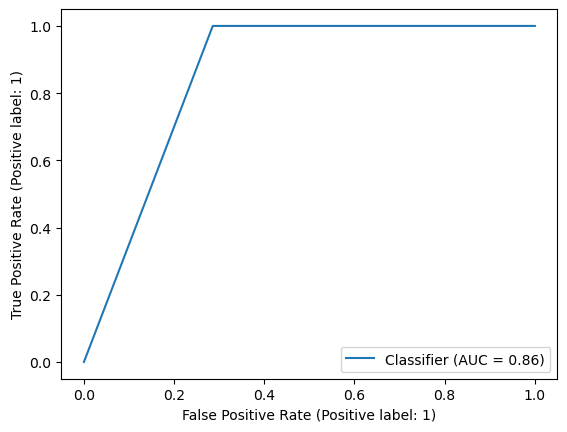

Mean Specificity= 0.7428571428571429 Std: 0.05714285714285712
Intervalo de confiança p < 0.95 0.5842031368458401 < x < 0.9015111488684456
Mean Sensibility= 1.0  Std: 0.0
Intervalo de confiança p < 0.95 nan < x < nan
Mean Accuracy = 0.85 Sdt: 0.033333333333333305
Intervalo de confiança p < 0.95 0.7574518298267401 < x < 0.9425481701732599
Mean False Positive Rate = 0.2571428571428571 Sdt: 0.05714285714285712
Intervalo de confiança p < 0.95 0.0984888511315544 < x < 0.41579686315415987


c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [125]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=seed)
model = gridSearch(model, param_grid_random_forest, cv, x_train, y_train)
scores_rf = evaluate_model(model, x_train, y_train, cv)
estimators_rf = scores_rf['estimator']
best_rf = get_best_classifier(scores_rf)
(list_accuracy_rf, list_sensibility_rf, list_specificity_rf, list_false_positive_rate_rf) = evaluate_kfold(estimators_rf,  x_test, y_test)

In [126]:
evaluate_estimator(best_rf, x_total, y_total)

----------------------------------------
Accuracy = 0.95
Specificity = 0.9
Sensibility = 1.0
False Positive rate: 0.09999999999999998
----------------------------------------


In [127]:
evaluate_estimator(best_rf, x_test, y_test)

----------------------------------------
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857
----------------------------------------


In [128]:
pred = marjoritary_vote(estimators_rf, x_test)
print_metrics(y_test, pred)

----------------------------------------
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857
----------------------------------------


In [129]:
def saveModel(model, path):
    joblib.dump(model, path)
    
def saveScaler(scaler, path):
    joblib.dump(scaler, path)

In [171]:
# Salvando o modelo de arvore de decisao
joblib.dump(logistic_best, "C:\\Users\\pveso\\Documents\\heart_attack_analysis\\src\\Hep\\Models\\logistic.pkl")
#joblib.dump(scaler, "C:\\Users\\pveso\\Documents\\heart_attack_analysis\\src\\Hep\\Models\\scaler.pkl")

['C:\\Users\\pveso\\Documents\\heart_attack_analysis\\src\\Hep\\Models\\logistic.pkl']

In [92]:
import Hep.inference_hep as inf
import os
import json

hep = inf.Hep()
json_data = hep.getJsonFromFile('C:\\Users\\pveso\\Documents\\heart_attack_analysis\\data\\JSON\\Hep\\neg_0.json')
json_readings = json_data["readings"]
potential = []
current = []
    
for i in range(len(json_readings)):
    sample = json.loads(json_readings[i])
    v = float(sample["V"])
    c = float(sample["I"])
    potential.append(v)
    current.append(c)


FileNotFoundError: [Errno 2] No such file or directory: 'src\\Hep\\Models\\scaler.pkl'

In [93]:
fft_current = hep.transformFourier(np.array(current))
plt.plot(fft_current)
plt.show()

NameError: name 'hep' is not defined

neg_0.json
neg_1.json
neg_2.json
neg_3.json
neg_4.json
neg_5.json
neg_6.json
neg_7.json
neg_8.json
neg_9.json
pos_0.json
pos_1.json
pos_2.json
pos_3.json
pos_4.json
pos_5.json
pos_6.json
pos_7.json
pos_8.json
pos_9.json


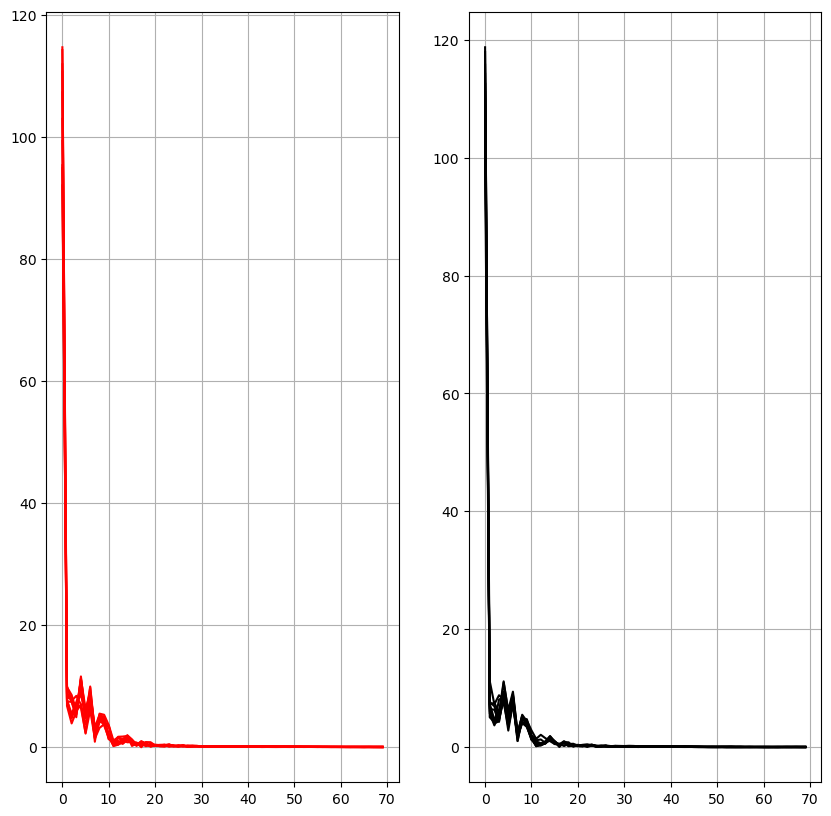

In [108]:
filepath = "C:\\Users\\pveso\\Documents\\heart_attack_analysis\\data\\JSON\\Hep"
files = os.listdir(filepath)
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,10))

for file in files:
    
    if ('.json' in file):
        print(file)
        json_ = (hep.getJsonFromFile(os.path.join(filepath, file)))
        json_readings = json_["readings"]
        potential = []
        current = []
        
        for i in range(len(json_readings)):
            sample = json.loads(json_readings[i])
            v = float(sample["V"])
            c = float(sample["I"])
            potential.append(v)
            current.append(c)
            
        if ('pos' in file):
            ax[0].plot(hep.transformFourier(np.array(current)), color = 'r')
        elif ('neg' in file):
            ax[1].plot(hep.transformFourier(np.array(current)), color = 'black')
ax[0].grid()
ax[1].grid()
plt.show()

In [180]:
y_test

array([0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0.])

In [184]:
classifier = joblib.load("C:\\Users\\pveso\\Documents\\heart_attack_analysis\\src\\Hep\\Models\\logistic.pkl")
classifier.predict(x_test[1].reshape(1,-1))

array([0.])

In [186]:
X_less_features.values[0].reshape(1, -1)

array([[4.78148079e+00, 4.76247406e+00, 1.97294006e+01, 4.55437164e+01,
        5.52545166e+00, 3.92100657e-01, 6.20807251e+02, 9.56296158e+00]])

In [185]:
loaded_scaler = joblib.load('.\Hep\std_scaler.bin')
loaded_scaler.transform(X_less_features.values[0].reshape(1, -1))

array([[-0.51689328, -0.44947625,  0.06872018, -0.60278733, -1.05541263,
        -0.82019238, -0.50258775, -0.51689332]])

In [131]:
#best_rf.predict(x_sanity)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

# Implementando uma MLP

In [133]:
param_grid_mlp = {
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.1, 1.0], 
}

Best Params
{'activation': 'tanh', 'alpha': 0.0001, 'solver': 'adam'}
Estimator 0
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


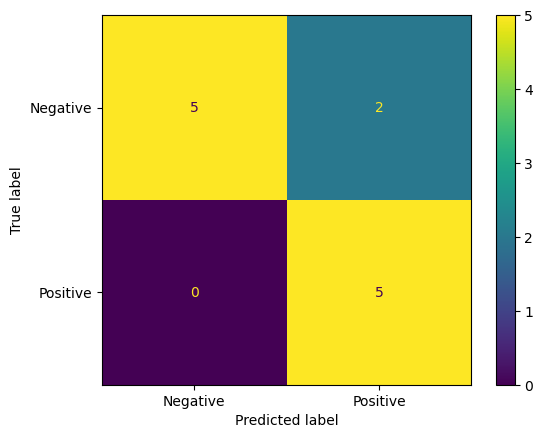

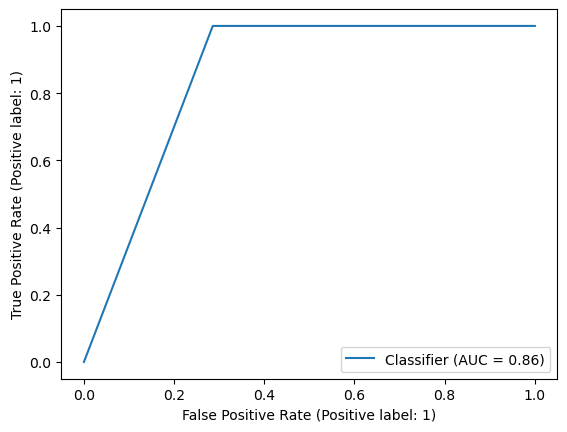

Estimator 1
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


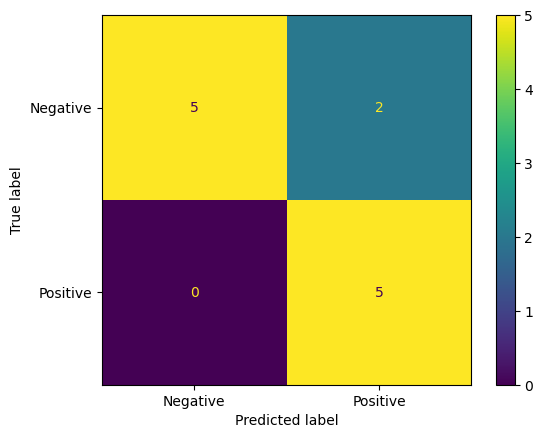

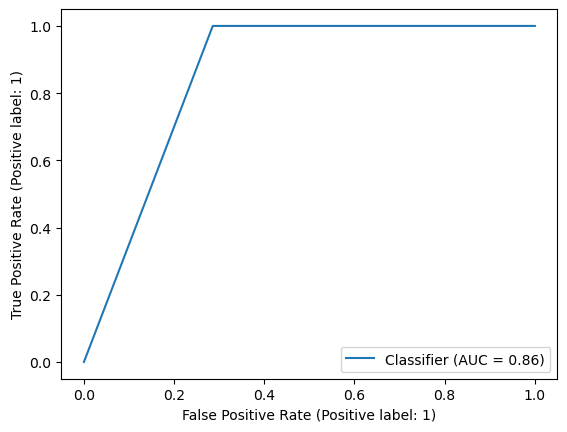

Estimator 2
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


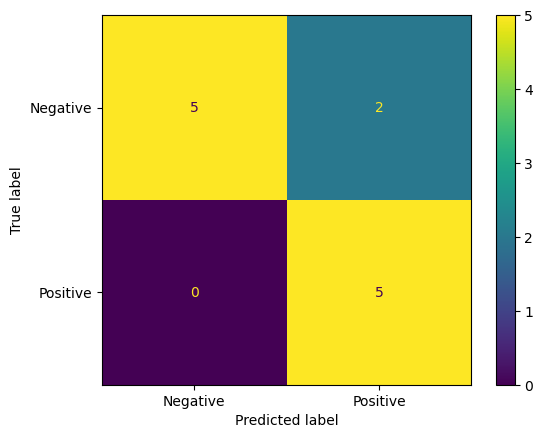

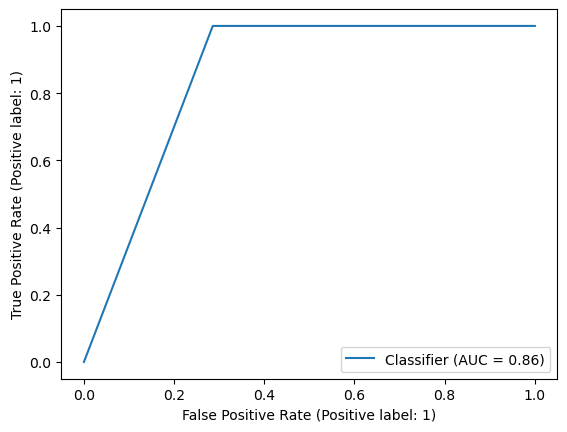

Estimator 3
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


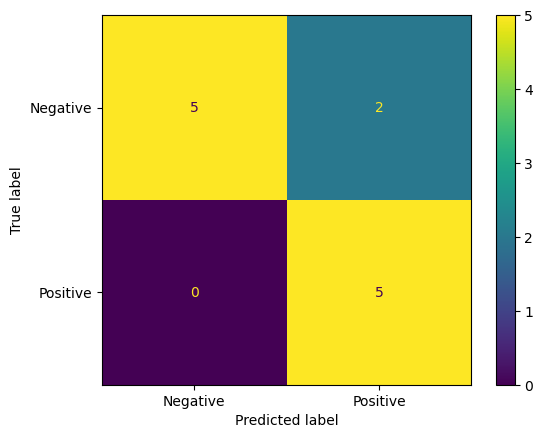

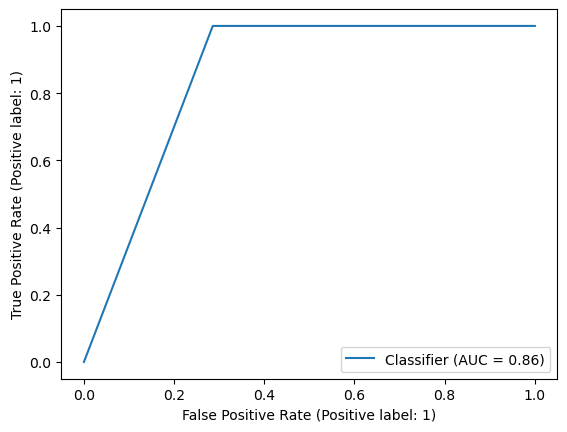

Estimator 4
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


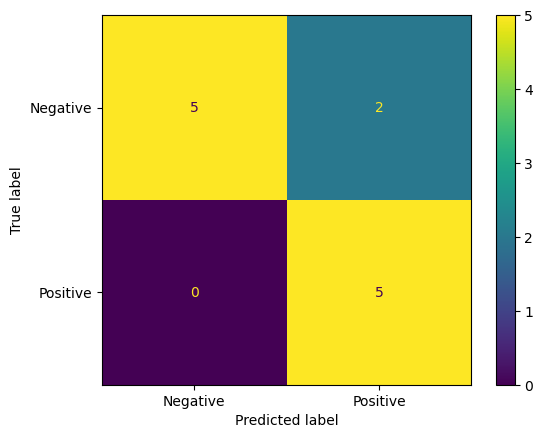

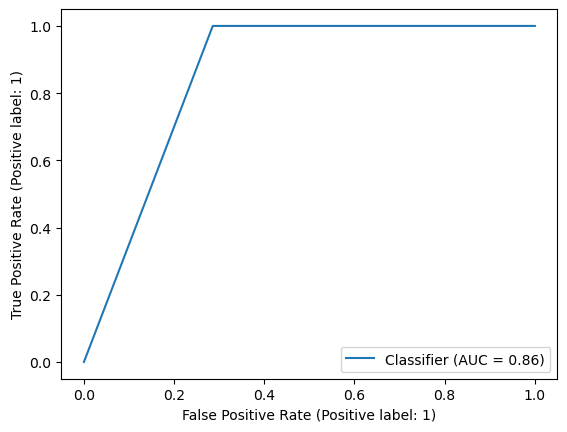

Mean Specificity= 0.7142857142857143 Std: 0.0
Intervalo de confiança p < 0.95 nan < x < nan
Mean Sensibility= 1.0  Std: 0.0
Intervalo de confiança p < 0.95 nan < x < nan
Mean Accuracy = 0.8333333333333334 Sdt: 0.0
Intervalo de confiança p < 0.95 nan < x < nan
Mean False Positive Rate = 0.2857142857142857 Sdt: 0.0
Intervalo de confiança p < 0.95 nan < x < nan


c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [134]:
mlp = MLPClassifier(random_state=seed, max_iter=10000, verbose=False)
mlp = gridSearch(mlp, param_grid_mlp, cv, x_train, y_train)
scores_mlp = evaluate_model(mlp, x_train, y_train, cv)
estimators_mlp = scores_mlp['estimator']
best_mlp = get_best_classifier(scores_mlp)
(list_accuracy_mlp, list_sensibility_mlp, list_specificity_mlp, list_false_positive_rate_mlp) = evaluate_kfold(estimators_mlp, X_total=x_test, y_total=y_test)

In [135]:
evaluate_estimator(best_mlp, x_test, y_test)

----------------------------------------
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857
----------------------------------------


In [136]:
evaluate_estimator(best_mlp, x_total, y_total)

----------------------------------------
Accuracy = 0.95
Specificity = 0.9
Sensibility = 1.0
False Positive rate: 0.09999999999999998
----------------------------------------


In [139]:
best_mlp.predict(x_sanity)

array([1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1], dtype=int64)

Implementando o XGBoost

c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
11000 fits failed out of a total of 20000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2000 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\sklearn\ensemble\_gb.py", line 270, in _check_params
    "n_estimators must be great

Best Params
{'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'exponential', 'n_estimators': 300}
Estimator 0
Accuracy = 0.8333333333333334
Specificity = 0.8571428571428571
Sensibility = 0.8
False Positive rate: 0.1428571428571429


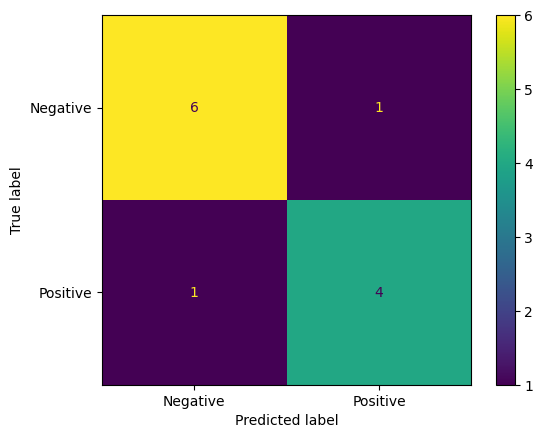

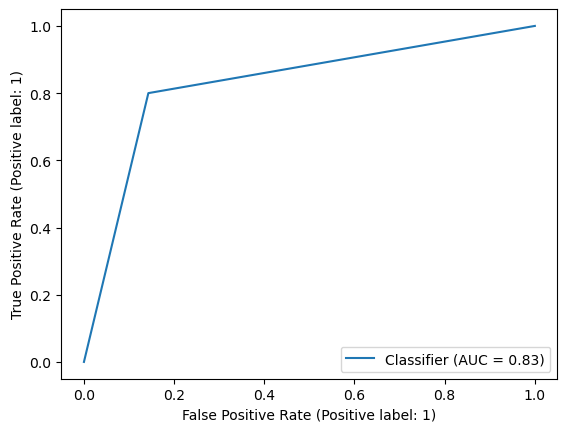

Estimator 1
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


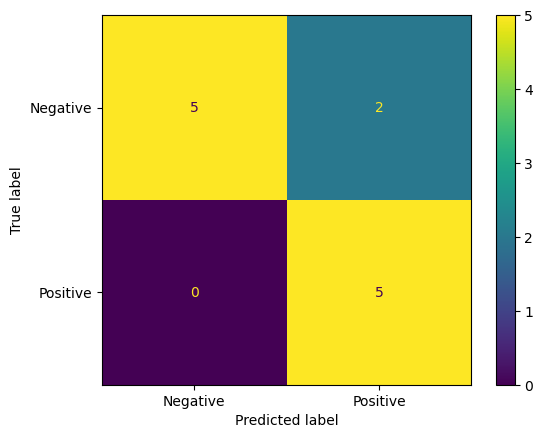

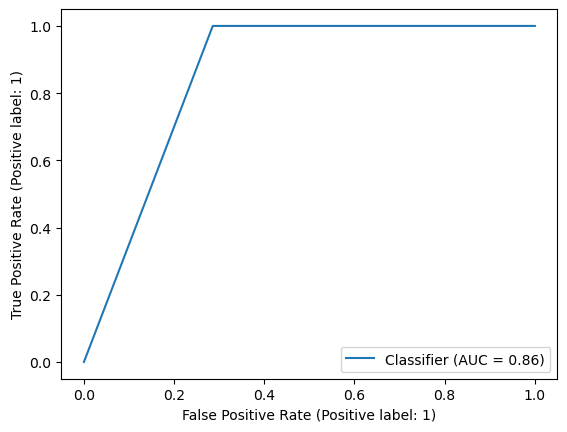

Estimator 2
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


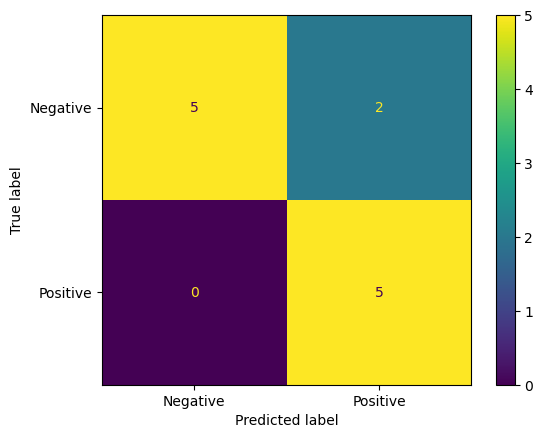

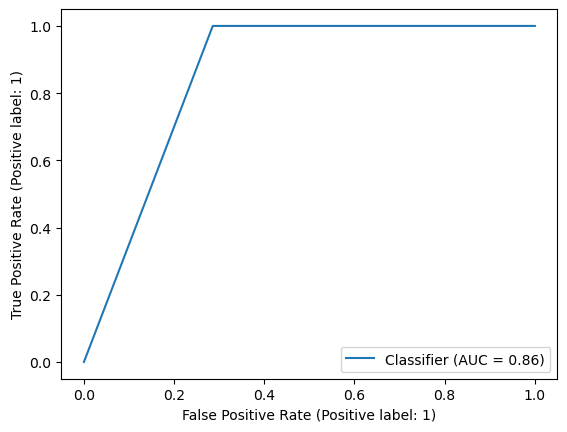

Estimator 3
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


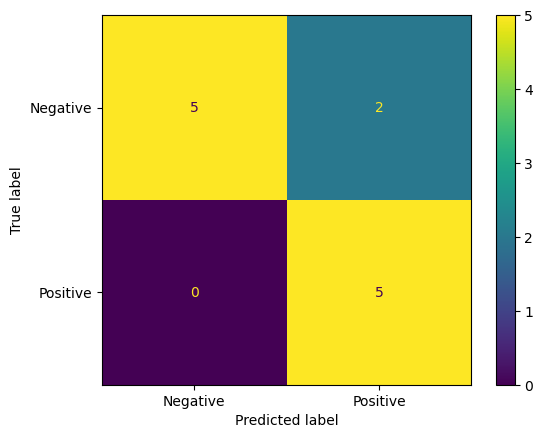

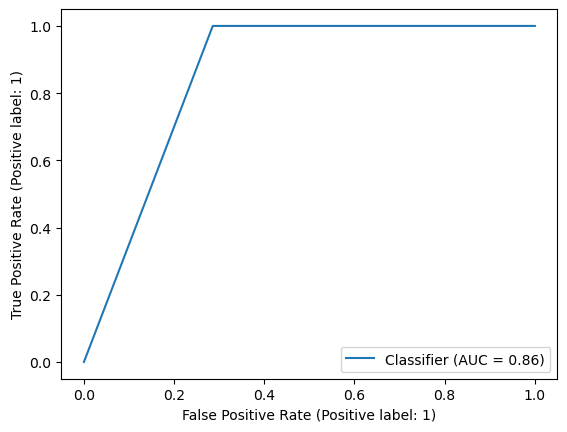

Estimator 4
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857


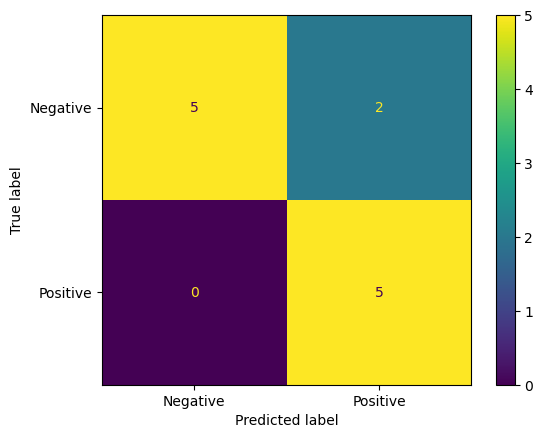

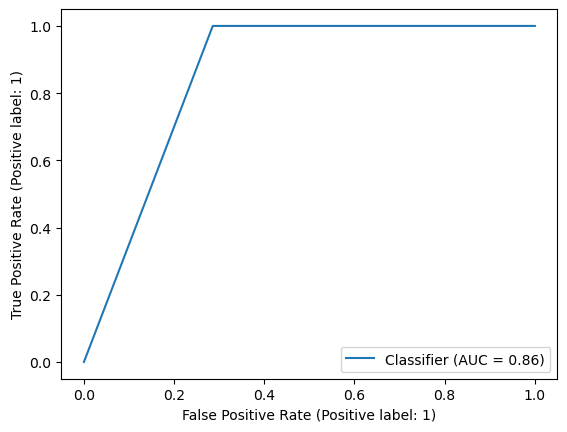

Mean Specificity= 0.7428571428571429 Std: 0.05714285714285712
Intervalo de confiança p < 0.95 0.5842031368458401 < x < 0.9015111488684456
Mean Sensibility= 0.96  Std: 0.07999999999999999
Intervalo de confiança p < 0.95 0.7378843915841761 < x < 1.0
Mean Accuracy = 0.8333333333333334 Sdt: 0.0
Intervalo de confiança p < 0.95 nan < x < nan
Mean False Positive Rate = 0.2571428571428571 Sdt: 0.05714285714285712
Intervalo de confiança p < 0.95 0.0984888511315544 < x < 0.41579686315415987


c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [137]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model = gridSearch(model, param_grid_gradient, cv, x_train, y_train)
scores_boost = evaluate_model(model, x_train, y_train, cv)
best_boost = get_best_classifier(scores_boost)
estimators_tree = scores_tree['estimator']
(list_accuracy_gradient, list_sensibility_gradient, list_specificity_gradient, list_false_positive_rate_greadient) = evaluate_kfold(estimators_tree, X_total=x_test, y_total=y_test)

In [99]:
evaluate_estimator(best_boost, x_test, y_test)

----------------------------------------
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857
----------------------------------------


In [100]:
evaluate_estimator(best_boost, x_total, y_total)

----------------------------------------
Accuracy = 0.95
Specificity = 0.9
Sensibility = 1.0
False Positive rate: 0.09999999999999998
----------------------------------------


# Implementando o voto majoritário dos classificadores
Implementando o voto majoritário entre Regressão Logística, Árvore de Decisão e random forest, svm e knn

In [101]:
pred = marjoritary_vote([logistic_best, best_svm, best_tree, best_mlp, best_rf], x_total)
print_metrics(y_total, pred)

----------------------------------------
Accuracy = 0.95
Specificity = 0.9
Sensibility = 1.0
False Positive rate: 0.09999999999999998
----------------------------------------


In [102]:
pred = marjoritary_vote([logistic_best, best_svm, best_tree, best_mlp], x_test)
print_metrics(y_test, pred)

----------------------------------------
Accuracy = 0.8333333333333334
Specificity = 0.7142857142857143
Sensibility = 1.0
False Positive rate: 0.2857142857142857
----------------------------------------


Aplicando os testes estatísticos Friedman e Nemenyi

A primeira coisa que temos que fazer é verificar se cada uma dessas medidas apresentam uma distribuição normal através do teste de Shapiro-Wilker
Se a distribuição é Normal, aplica o teste ANOVA
Se a distribuição não é Normal aplica o teste de Friedman

In [164]:
accuracy_measures = np.array([list_accuracy_logistic,
                              list_accuracy_knn,
                              list_accuracy_rf,
                              list_accuracy_svc,
                              list_accuracy_tree,
                              list_accuracy_mlp,
                              list_accuracy_gradient])

sensibility_measures = np.array([list_sensibility_logistic,
                              list_sensibility_knn,
                              list_sensibility_rf,
                              list_sensibility_svc,
                              list_sensibility_tree,
                              list_sensibility_mlp,
                              list_sensibility_gradient])

specificity_measures = np.array([list_specificity_logistic,
                              list_specificity_knn,
                              list_specificity_rf,
                              list_specificity_svc,
                              list_specificity_tree,
                              list_specificity_mlp, 
                              list_specificity_gradient])

false_p_measures = np.array([list_false_positive_rate_logistic,
                              list_false_positive_rate_knn,
                              list_false_positive_rate_rf,
                              list_false_positive_rate_svc,
                              list_false_positive_rate_tree,
                              list_false_positive_rate_mlp,
                              list_false_positive_rate_greadient])

In [165]:
list_accuracy_logistic

[0.9166666666666666,
 0.9166666666666666,
 0.9166666666666666,
 0.9166666666666666,
 0.9166666666666666]

In [166]:
np.mean(accuracy_measures, axis=1)

array([0.91666667, 0.88333333, 0.85      , 0.83333333, 0.83333333,
       0.83333333, 0.83333333])

In [167]:
np.mean(sensibility_measures, axis = 1)

array([0.8 , 0.96, 1.  , 1.  , 0.96, 1.  , 0.96])

In [168]:
np.mean(specificity_measures, axis = 1)

array([1.        , 0.82857143, 0.74285714, 0.71428571, 0.74285714,
       0.71428571, 0.74285714])

In [169]:
np.mean(false_p_measures, axis = 1)

array([0.        , 0.17142857, 0.25714286, 0.28571429, 0.25714286,
       0.28571429, 0.25714286])

In [170]:
columns_classifiers = ["reg_logistic", "knn", "random_for", "svm", "deci_tree", "MLP", "gradient"]
pd.DataFrame(accuracy_measures.T, columns=columns_classifiers).to_csv("../data/results/accuracy_measures.csv")
pd.DataFrame(sensibility_measures.T, columns=columns_classifiers).to_csv("../data/results/sensibility_measures.csv")
pd.DataFrame(specificity_measures.T, columns=columns_classifiers).to_csv("../data/results/specificity_measures.csv")
pd.DataFrame(false_p_measures.T, columns=columns_classifiers).to_csv("../data/results/false_positive_rate_measures.csv")

In [68]:
# Aplicando o teste de Shapiro-Wilk para determinar a normalidade dos dados
print("Accuracy Test")
print("**********************************\n")
for i in range(accuracy_measures.shape[0]):
    stats_, p = stats.shapiro(accuracy_measures[i,:])
    print(stats_, p)
    
# Aplicando o teste de Shapiro-Wilk para determinar a normalidade dos dados
print("Sensibility")
print("**********************************\n")
for i in range(sensibility_measures.shape[1]):
    stats_, p = stats.shapiro(sensibility_measures[i,:])
    print(stats_, p)
    
# Aplicando o teste de Shapiro-Wilk para determinar a normalidade dos dados
print("Specificity")
print("**********************************\n")
for i in range(specificity_measures.shape[1]):
    stats_, p = stats.shapiro(specificity_measures[i,:])
    print(stats_, p)
    
# Aplicando o teste de Shapiro-Wilk para determinar a normalidade dos dados
print("False Positive rate")
print("**********************************\n")
for i in range(false_p_measures.shape[1]):
    stats_, p = stats.shapiro(false_p_measures[i,:])
    print(stats_, p)

Accuracy Test
**********************************

1.0 1.0
0.770907998085022 0.04595435410737991
0.7709077596664429 0.04595416039228439
0.8810375332832336 0.3140389621257782
0.8810375332832336 0.3140389621257782
0.8810375332832336 0.3140389621257782
Sensibility
**********************************

1.0 1.0
0.5521817207336426 0.00013097839837428182
0.5521818399429321 0.00013097876217216253
1.0 1.0
0.8810377717018127 0.31404030323028564
Specificity
**********************************

1.0 1.0
0.6840287446975708 0.006469968240708113
0.5521816611289978 0.00013097790360916406
0.8810377717018127 0.31404030323028564
1.0 1.0
False Positive rate
**********************************

1.0 1.0
0.6840287446975708 0.006469981279224157
0.5521817207336426 0.00013097839837428182
0.8810376524925232 0.3140396773815155
1.0 1.0


c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


O teste de Shapiro-Wilk revelou que não dá para descartar a normal com relação a acurácia e sensibilidade
O teste também revelou que dá para descartar a normal com relação a specificidade e taxa de falsos positivos


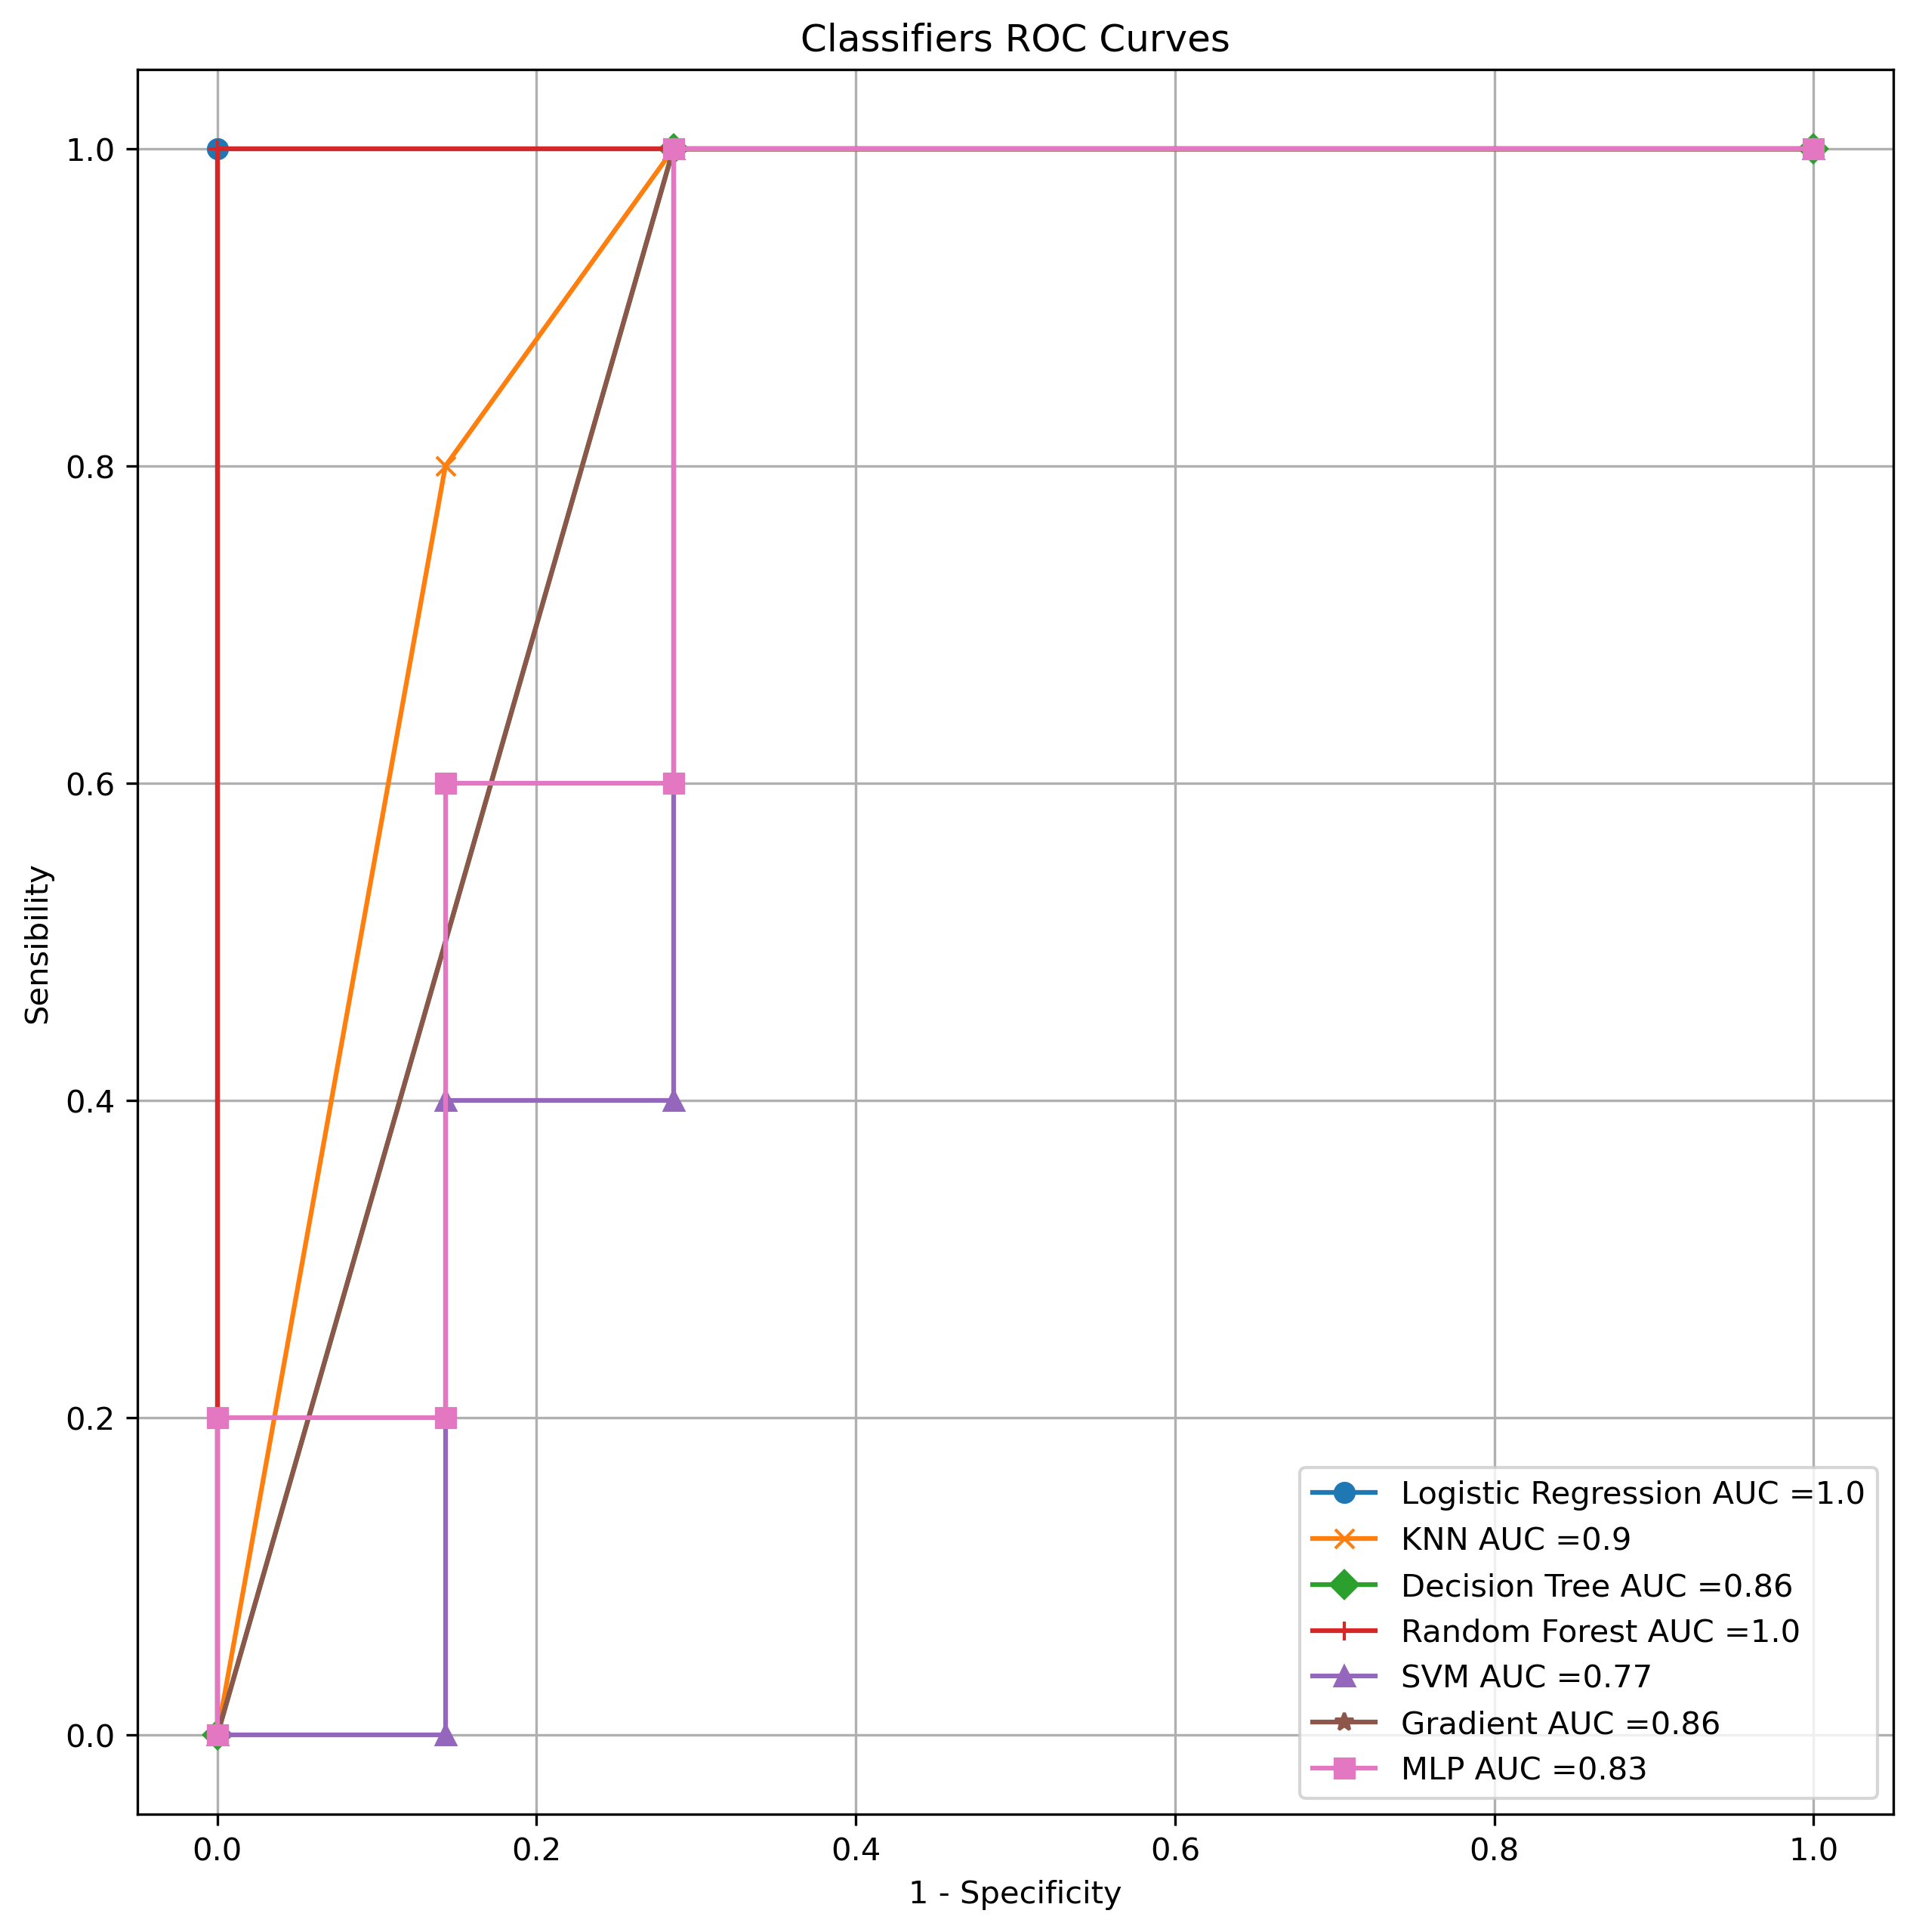

In [156]:
# Observando os classificadores com relação a curva ROC
array_classifiers = [logistic_best, knn_best, best_tree, best_rf, best_svm, best_boost, best_mlp]
array_names = ["Logistic Regression", "KNN", "Decision Tree", "Random Forest", "SVM", "Gradient", "MLP"]
markers = ['o', 'x', 'D', '+', '^','*', 's']
plt.figure(figsize=(10,10), dpi = 300)

for i, cls in enumerate(array_classifiers):
    pred_y = cls.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, pred_y)
    auc = round(metrics.roc_auc_score(y_test, pred_y), 2)
    plt.plot(fpr, tpr, label="" + array_names[i] + " AUC =" + str(auc), marker=markers[i])

plt.legend()
plt.title("Classifiers ROC Curves")
plt.ylabel("Sensibility")
plt.grid(True)
plt.xlabel("1 - Specificity")
plt.show()


Text(0.5, 0, '1 - Specificity')

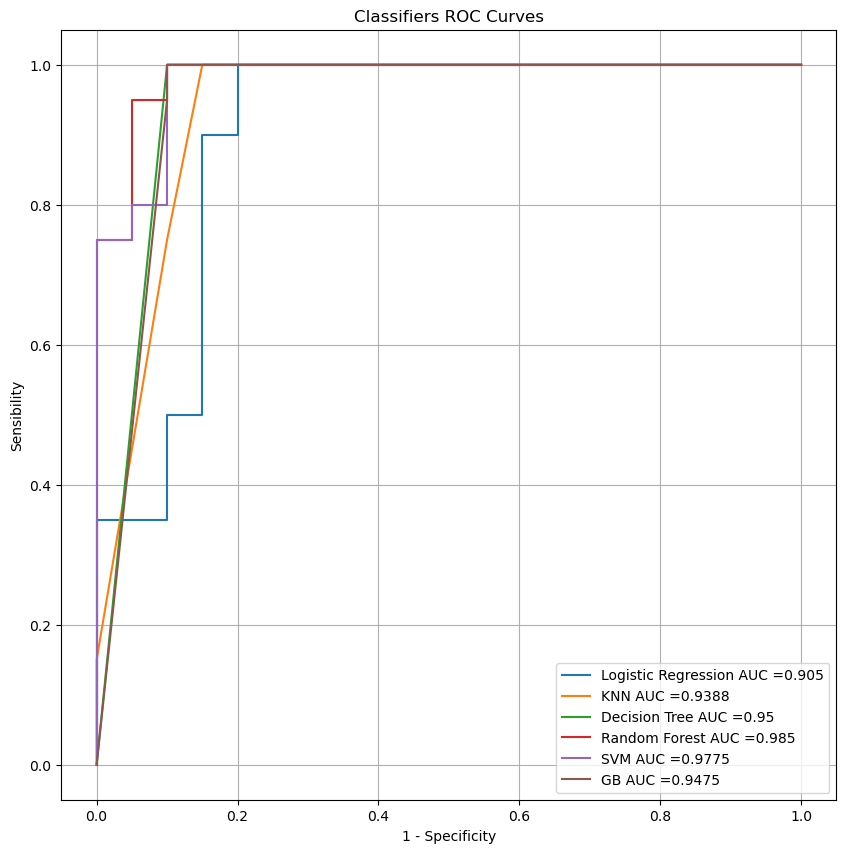

In [71]:
plt.figure(figsize=(10,10))
for i, cls in enumerate(array_classifiers):
    pred_y = cls.predict_proba(x_total)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_total, pred_y)
    auc = round(metrics.roc_auc_score(y_total, pred_y), 4)
    plt.plot(fpr, tpr, label="" + array_names[i] + " AUC =" + str(auc))
    

plt.legend()
plt.title("Classifiers ROC Curves")
plt.ylabel("Sensibility")
plt.grid(True)
plt.xlabel("1 - Specificity")